# Predicting NCAA Football Coach Salaries

* Jennifer Mead, May 2020
---



# Introduction

This document includes code and commentary from the technical perspective. Look separately for the report for the client (athletic director). 

### Problem statement
NCAA football coaches make impressive salaries, because a successful football program has the potential to bring a lot of revenue and prestige to the school. But what is a fair salary for a coach? What is a salary that will retain your coach instead of having them go to another school? 

In the case study for this assignment, the goal is to gather, clean, visualize, analyze, and model data on football coach salaries in order to recommend to the Syracuse athletic director what salary should be offered in negotiations with the football coach. 

The original data includes variables such the salary in 2015, the conference name, the bonus amount, and the buyout amount. Note that these are different fields than those in the case study, which included additional fields such as coach tenure, win percentage, graduation rate, enrollment, tuition, and team rank. 

The first problem is to supplement the given data with other data that might help forecast coach salaries. In addition to the suggestions from the case study, I've also collected variables such as media rank (for the tv viewership of the area), college sports fan rank (for the city), median income of the state, and other details. We won't know if these are better or worse than the original data in the case study until we model them. 

If you are familiar with NCAA football, you know that conference is a big predictor of salary and has a strong correlation with variables like stadium size and win percentage. One of the challenges in this problem is to make a model that isn't just conference, but shows more subtlety in its recommendations.

### Approach

* The original dataset is imported. I look at some basic statistics and decide to use median values per conference to fill in blanks. 
* Each additional dataset is imported. 
* It is joined to the base data, typically using fuzzy matching (which finds approximate matches), and then the most egregious errors are fixed by hand.
* The data is visualized to look for patterns, and then transformed if necessary to make it more useful for modeling.
* Fields are then compared to each other and to salary (the variable we want to predict) to look for correlation. Some columns are removed because they correlate too much with other fields or don't have quality data.
* I run several models and compare the results. There are an infinite number of models and tuning parameters to run, so I've chosen to use linear regression and random forest. 
* For the best models, I then predict the suggested salary (with "error bars"). 

### Audience
This report is intended for someone who wants to see the code, interim graphs, and comments. For the non-technical version, see the Report for the Athletic Director. 


In [0]:
# install packages
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt  #viz
import seaborn as sns            #viz
from scipy.stats import uniform
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error 
import math 



# un-comment the pip install when you need to run it 
!pip install fuzzymatcher
from fuzzymatcher import link_table, fuzzy_left_join

# reference: https://stackoverflow.com/questions/51342408/how-do-i-install-python-packages-in-googles-colab

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for metaphone: filename=Metaphone-0.6-cp36-none-any.whl size=13906 sha256=3d8ce8c4a6e1f7939c63e49edb8acc0cde9dbee0b9211954584972b3cbd21ab0
  Stored in directory: /root/.cache/pip/wheels/4e/7c/f7/162d726fc83491ef23c7a0b989005024eb83a1408c96f32eaf
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144793 sha256=36595dc5fd4d2d6c8ce8d54f48dde33f40e4023e7849ebe8a091795e2fb27783
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built metaphone python-Levenshtein


In [0]:
# set up environment display in colab
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

# reference: https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/

# Gather data, prepare it, summarize it, visualize it

## Import original coaches data


In [0]:
# CREATES COACH1, the original data
# DATASOURCE: assignment

# First import base "coaches9" data
# modifications made before import:
# deleted assistant pay column because it was always zero
# columns with currency turned into integers without dollar signs
# deleted Baylor, Brigham Young, Rice, Southern Methodist because there was no pay information in five columns
# Conference column renamed Conf_Abbr


# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
coach1 = pd.read_csv("/content/drive/My Drive/Colab data HW 1/Coaches_originaldata.csv", 
                     na_values=['--']
                    ) 
coach1 = coach1.rename(index=coach1.School)
print(coach1.dtypes)
print(coach1.shape)
coach1.head(13)

# reference: https://www.shanelynn.ie/python-pandas-read_csv-load-data-from-csv-files/
# reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

School        object
Conf_Abbr     object
Coach         object
SchoolPay      int64
TotalPay       int64
Bonus        float64
BonusPaid    float64
Buyout       float64
dtype: object
(125, 8)


,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout
Air Force,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,nan,nan
Akron,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00
Alabama,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00
Alabama at Birmingham,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00
Appalachian State,Appalachian State,Sun Belt,Scott Satterfield,712500,712500,295000.00,145000.00,2160417.00
Arizona,Arizona,Pac-12,Kevin Sumlin,1600000,2000000,2025000.00,nan,10000000.00
Arizona State,Arizona State,Pac-12,Herm Edwards,2000000,2000000,3010000.00,nan,8166667.00
Arkansas,Arkansas,SEC,Chad Morris,3500000,3500000,1000000.00,nan,12500000.00
Arkansas State,Arkansas State,Sun Belt,Blake Anderson,825000,825000,185000.00,25000.00,300000.00
Army,Army,Ind.,Jeff Monken,932521,932521,nan,nan,nan


In [0]:
# create a new variable that splits the media bonuses out of TotalPay
coach1['MediaPay'] = coach1['TotalPay'] - coach1['SchoolPay']
coach1.head(10)

,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay
Air Force,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,nan,nan,0
Akron,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00,1500
Alabama,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00,0
Alabama at Birmingham,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00,0
Appalachian State,Appalachian State,Sun Belt,Scott Satterfield,712500,712500,295000.00,145000.00,2160417.00,0
Arizona,Arizona,Pac-12,Kevin Sumlin,1600000,2000000,2025000.00,nan,10000000.00,400000
Arizona State,Arizona State,Pac-12,Herm Edwards,2000000,2000000,3010000.00,nan,8166667.00,0
Arkansas,Arkansas,SEC,Chad Morris,3500000,3500000,1000000.00,nan,12500000.00,0
Arkansas State,Arkansas State,Sun Belt,Blake Anderson,825000,825000,185000.00,25000.00,300000.00,0
Army,Army,Ind.,Jeff Monken,932521,932521,nan,nan,nan,0


In [0]:
print(coach1.describe().round(0))

# SchoolPay ranges from $390,000 to more than $8 million per year, with an average salary near $2.4 million. 

       SchoolPay   TotalPay      Bonus  BonusPaid      Buyout  MediaPay
count     125.00     125.00     107.00      88.00      107.00    125.00
mean  2410301.00 2417061.00  874178.00  149524.00  8119107.00   6760.00
std   1881377.00 1885752.00  634697.00  238758.00 10461349.00  46919.00
min    390000.00  390000.00   50000.00       0.00        0.00      0.00
25%    801504.00  805850.00  395000.00   19375.00  1200000.00      0.00
50%   1831580.00 1900008.00  775000.00   63750.00  4000000.00      0.00
75%   3605000.00 3617500.00 1150000.00  180000.00 11065000.00      0.00
max   8307000.00 8307000.00 3100000.00 1350000.00 68125000.00 400000.00


In [0]:
# Where do we have blanks? 
# Answer: 38 columns are missing some information in Bonus, Bonus Paid, or Buyout

coach1_nans = coach1[coach1.isna().any(axis=1)]
print(coach1_nans.shape)
coach1_nans.head(13)

# reference: https://stackoverflow.com/questions/43424199/display-rows-with-one-or-more-nan-values-in-pandas-dataframe
# sample: df1 = df[df.isna().any(axis=1)]

(38, 9)


,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay
Air Force,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,nan,nan,0
Arizona,Arizona,Pac-12,Kevin Sumlin,1600000,2000000,2025000.00,nan,10000000.00,400000
Arizona State,Arizona State,Pac-12,Herm Edwards,2000000,2000000,3010000.00,nan,8166667.00,0
Arkansas,Arkansas,SEC,Chad Morris,3500000,3500000,1000000.00,nan,12500000.00,0
Army,Army,Ind.,Jeff Monken,932521,932521,nan,nan,nan,0
Boston College,Boston College,ACC,Steve Addazio,2514859,2514859,nan,nan,nan,0
Central Florida,Central Florida,AAC,Josh Heupel,1700000,1700000,250000.00,nan,3587500.00,0
Duke,Duke,ACC,David Cutcliffe,2540928,2540928,nan,nan,nan,0
Florida,Florida,SEC,Dan Mullen,6070000,6070000,925000.00,nan,12000000.00,0
Florida State,Florida State,ACC,Willie Taggart,5000000,5000000,1475000.00,nan,21958333.00,0


In [0]:
# It looks like BonusPaid and Buyout can be zero, but Bonus is never zero.

conf_min = coach1.groupby('Conf_Abbr').min().round(0)
conf_min['BonusPct'] = conf_min['BonusPaid']/conf_min['TotalPay']
conf_min['BonusPaidPct'] = conf_min['BonusPaid']/conf_min['TotalPay']
conf_min['BuyoutPct'] = conf_min['Buyout']/conf_min['Bonus']
conf_min

,School,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,BonusPct,BonusPaidPct,BuyoutPct
Conf_Abbr,,,,,,,,,,,
AAC,Central Florida,Charlie Strong,1000000,1000000,250000.00,0.00,192308.00,0,0.00,0.00,0.77
ACC,Boston College,Bobby Petrino,1831580,1831580,435000.00,50000.00,4000000.00,0,0.03,0.03,9.20
Big 12,Iowa State,Bill Snyder,1701109,1701109,580000.00,0.00,3000000.00,0,0.00,0.00,5.17
Big Ten,Illinois,Chris Ash,1830000,1830000,625000.00,0.00,2000000.00,0,0.00,0.00,3.20
C-USA,Alabama at Birmingham,Bill Clark,500000,500000,120000.00,0.00,556389.00,0,0.00,0.00,4.64
Ind.,Army,Brian Kelly,419640,419640,220000.00,20000.00,300000.00,0,0.05,0.05,1.36
MAC,Akron,Chris Creighton,411000,412500,205000.00,0.00,522300.00,0,0.00,0.00,2.55
Mt. West,Air Force,Bob Davie,425004,486504,210000.00,0.00,300000.00,0,0.00,0.00,1.43
Pac-12,Arizona,Chip Kelly,1500000,1500000,725000.00,75000.00,4037517.00,0,0.05,0.05,5.57


In [0]:
# Look at average for each conference
# also look at what percentage of Bonus BonusPaid and Buyout tend to be, on average

conf_mean = coach1.groupby('Conf_Abbr').mean().round(0)
conf_mean['BonusPct'] = conf_mean['BonusPaid']/conf_mean['TotalPay']
conf_mean['BonusPaidPct'] = conf_mean['BonusPaid']/conf_mean['TotalPay']
conf_mean['BuyoutPct'] = conf_mean['Buyout']/conf_mean['TotalPay']
conf_mean

,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,BonusPct,BonusPaidPct,BuyoutPct
Conf_Abbr,,,,,,,,,
AAC,1656268.00,1656268.00,678214.00,67333.00,3236758.00,0.00,0.04,0.04,1.95
ACC,3409629.00,3433797.00,1281615.00,295702.00,15818620.00,24168.00,0.09,0.09,4.61
Big 12,4016756.00,4018145.00,1019375.00,141562.00,11146615.00,1389.00,0.04,0.04,2.77
Big Ten,4304014.00,4304014.00,1149306.00,174583.00,15019149.00,0.00,0.04,0.04,3.49
C-USA,839519.00,840084.00,516746.00,43593.00,2807372.00,565.00,0.05,0.05,3.34
Ind.,985816.00,985816.00,262500.00,20000.00,916395.00,0.00,0.02,0.02,0.93
MAC,579836.00,579961.00,374954.00,52858.00,1170910.00,125.00,0.09,0.09,2.02
Mt. West,1000642.00,1005938.00,717250.00,166455.00,3340035.00,5296.00,0.17,0.17,3.32
Pac-12,2856578.00,2890119.00,1498000.00,205233.00,9443977.00,33542.00,0.07,0.07,3.27


In [0]:
# the median by conference looks like the most fair way to fill in blanks
conf_median = coach1.groupby('Conf_Abbr').median().round(0)
conf_median['BonusPct'] = conf_median['BonusPaid']/conf_median['TotalPay']
conf_median['BonusPaidPct'] = conf_median['BonusPaid']/conf_median['TotalPay']
conf_median['BuyoutPct'] = conf_median['Buyout']/conf_median['TotalPay']
conf_median

,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,BonusPct,BonusPaidPct,BuyoutPct
Conf_Abbr,,,,,,,,,
AAC,1664500.00,1664500.00,775000.00,45000.00,2112500.00,0.00,0.03,0.03,1.27
ACC,3038868.00,3038868.00,1340000.00,225000.00,14528125.00,0.00,0.07,0.07,4.78
Big 12,3703975.00,3703975.00,825000.00,68750.00,11283334.00,0.00,0.02,0.02,3.05
Big Ten,4095208.00,4095208.00,980000.00,137500.00,12636991.00,0.00,0.03,0.03,3.09
C-USA,800000.00,803004.00,504895.00,26250.00,2850000.00,0.00,0.03,0.03,3.55
Ind.,932521.00,932521.00,262500.00,20000.00,916395.00,0.00,0.02,0.02,0.98
MAC,492413.00,492413.00,380500.00,42500.00,965150.00,0.00,0.09,0.09,1.96
Mt. West,878788.00,879288.00,462500.00,50000.00,1476060.00,0.00,0.06,0.06,1.68
Pac-12,2752232.00,2752232.00,1180000.00,279167.00,8583334.00,0.00,0.10,0.10,3.12


In [0]:
# create dictionaries for these values because it will be easier to fill the values into the df later
conf_median_Bonus = dict(conf_median['Bonus'])
conf_median_BonusPaid = dict(conf_median['BonusPaid'])
conf_median_Buyout = dict(conf_median['Buyout'])
#print(conf_median_Bonus)
#print(conf_median_BonusPaid)
#print(conf_median_Buyout)

### Replace blanks

In [0]:
# first test on subset
#coach1_nans.Bonus = coach1_nans.Bonus.fillna(coach1_nans.Conf_Abbr.map(conf_median_Bonus))
#coach1_nans.BonusPaid = coach1_nans.BonusPaid.fillna(coach1_nans.Conf_Abbr.map(conf_median_BonusPaid))
#coach1_nans.Buyout = coach1_nans.Buyout.fillna(coach1_nans.Conf_Abbr.map(conf_median_Buyout))

# coach1_nans.head(10)
# reference: https://stackoverflow.com/questions/42848911/pandas-fill-in-nan-values-with-dictionary-references-another-column
# sample: df.B = df.B.fillna(df.A.map(dict))

In [0]:
#apply to full datset and check for blanks again
coach1.Bonus = coach1.Bonus.fillna(coach1.Conf_Abbr.map(conf_median_Bonus))
coach1.BonusPaid = coach1.BonusPaid.fillna(coach1.Conf_Abbr.map(conf_median_BonusPaid))
coach1.Buyout = coach1.Buyout.fillna(coach1.Conf_Abbr.map(conf_median_Buyout))

coach1_nans = coach1[coach1.isna().any(axis=1)]
print(coach1_nans.shape)
coach1_nans

# reference: https://stackoverflow.com/questions/42848911/pandas-fill-in-nan-values-with-dictionary-references-another-column
# sample: df.B = df.B.fillna(df.A.map(dict))

(0, 9)


,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay


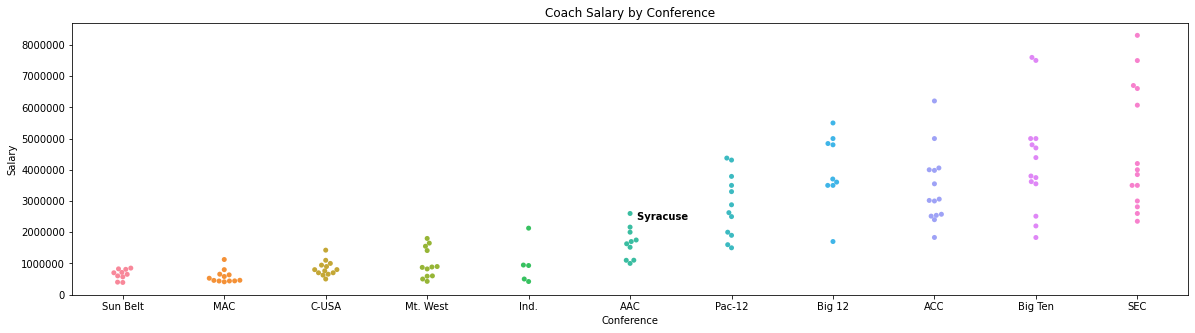

In [0]:
plt.figure(figsize=(20,5))
plt.title('Coach Salary by Conference')
plt.ticklabel_format(style='plain', axis='y')

ax = sns.swarmplot(x="Conf_Abbr", y="SchoolPay", data=coach1, 
                   order=[ "Sun Belt", "MAC", "C-USA", "Mt. West", "Ind.", "AAC", "Pac-12", "Big 12", "ACC", "Big Ten", "SEC"]
                   )
ax.text(5, coach1.loc[coach1.School =='Syracuse', 'SchoolPay'], "  Syracuse", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.set(xlabel='Conference', ylabel='Salary')
plt.show()

# references: 
# https://www.drawingfromdata.com/setting-figure-size-using-seaborn-and-matplotlib
# https://seaborn.pydata.org/generated/seaborn.swarmplot.html
# https://python-graph-gallery.com/4-add-title-and-axis-label/
# https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot
# https://stackoverflow.com/questions/36780948/seaborn-matplotlib-how-to-repress-scientific-notation-in-factorplot-y-axis

## Get more data to round out our dataset

### Import official conference names

In [0]:
# DATASOURCE: https://en.wikipedia.org/wiki/NCAA_Division_I
# removed columns, added Mt. West as a nickname before importing

data_confnames = pd.read_csv("/content/drive/My Drive/Colab data HW 1/Conference_names_nicknames.csv"
                    ) 
print(data_confnames.dtypes)
data_confnames.head(13)

Conference    object
Nicknames     object
dtype: object


,Conference,Nicknames
0,American Athletic Conference,The American
1,Atlantic Coast Conference,ACC
2,Big Ten Conference,Big Ten
3,Big 12 Conference,Big 12
4,Conference USA,C-USA
5,Division I FBS Independents,Ind.
6,Mid-American Conference,MAC
7,Mountain West Conference,Mt. West
8,Pac-12 Conference,Pac-12
9,Southeastern Conference,SEC


### Import data with the full school name, nickname, city, state, and conference

In [0]:
# DATA SOURCE: https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_institutions

data_schoolnames = pd.read_csv("/content/drive/My Drive/Colab data HW 1/School_Full_Name.csv"
                    ) 
print(data_schoolnames.shape)
print(data_schoolnames.dtypes)
data_schoolnames = data_schoolnames.drop(columns=['Team', 'SchoolType'])
data_schoolnames.head(13)

(350, 7)
SchoolFullName        object
SchoolCommonName      object
Team                  object
City                  object
State                 object
SchoolType            object
Primary conference    object
dtype: object


,SchoolFullName,SchoolCommonName,City,State,Primary conference
0,Abilene Christian University,Abilene Christian,Abilene,Texas,Southland Conference
1,University of Akron,Akron,Akron,Ohio,Mid-American Conference
2,University of Alabama,Alabama,Tuscaloosa,Alabama,Southeastern Conference
3,Alabama Agricultural and Mechanical University,Alabama A&M,Huntsville,Alabama,Southwestern Athletic Conference
4,University of Alabama at Birmingham,UAB,Birmingham,Alabama,Conference USA
5,Alabama State University,Alabama State,Montgomery,Alabama,Southwestern Athletic Conference
6,"University at Albany, SUNY",Albany,Albany,New York,America East Conference
7,Alcorn State University,Alcorn State,Lorman,Mississippi,Southwestern Athletic Conference
8,American University,American,"Washington, D.C.",District of Columbia,Patriot League
9,Appalachian State University,Appalachian State,Boone,North Carolina,Sun Belt Conference


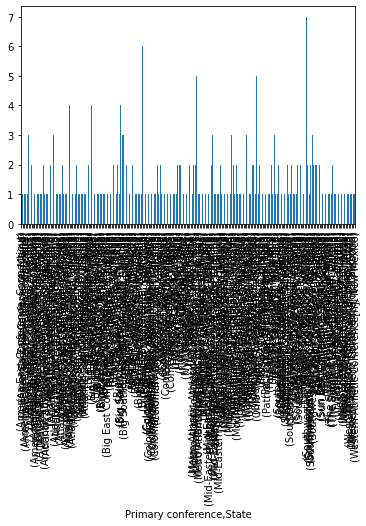

In [0]:
by_state = data_schoolnames.groupby(['Primary conference', 'State']).size()
by_state.plot.bar()

# reference: https://stackoverflow.com/questions/45299305/how-to-plot-pandas-groupby-values-in-a-graph
# sample: groups = df.groupby(['Gender','Married']).size()
# groups.plot.bar()

In [0]:
# that graph isn't pretty, but it does show us that there are a few outliers for states that have many conferences in them

### Import the official state names and their abbreviations

In [0]:
# DATA SOURCE: https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations

# before importing, removed most columns
data_stateabbr = pd.read_csv("/content/drive/My Drive/Colab data HW 1/State_Abbreviations.csv"
                    ) 
print(data_stateabbr.shape)
print(data_stateabbr.dtypes)
data_stateabbr.head(13)

(51, 3)
StateName       object
StateAbbr       object
StateAbbrAlt    object
dtype: object


,StateName,StateAbbr,StateAbbrAlt
0,Alabama,AL,Ala.
1,Alaska,AK,Alaska
2,Arizona,AZ,Ariz.
3,Arkansas,AR,Ark.
4,California,CA,Calif.
5,Colorado,CO,Colo.
6,Connecticut,CT,Conn.
7,Delaware,DE,Del.
8,District of Columbia,DC,D.C.
9,Florida,FL,Fla.


### Import the median household income for each state

In [0]:
# DATA SOURCE: https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income

# before importing, removed other years, plus any row that was blank
data_stateincome = pd.read_csv("/content/drive/My Drive/Colab data HW 1/State_Med_Income.csv"
                    ) 
print(data_stateincome.shape)
print(data_stateincome.dtypes)
data_stateincome.StateTerritory = data_stateincome.StateTerritory.str.strip() # to avoid error later
data_stateincome.head(13)

(53, 2)
StateTerritory    object
MedianHHIncome     int64
dtype: object


,StateTerritory,MedianHHIncome
0,"Washington, D.C.",75628
1,Maryland,75847
2,New Jersey,72222
3,Hawaii,73486
4,Massachusetts,70628
5,Connecticut,71346
6,California,64500
7,New Hampshire,70303
8,Alaska,73355
9,Washington,64129


(array([ 1.,  0.,  0.,  1.,  6., 15., 11.,  9.,  2.,  8.]),
 array([18626. , 24348.1, 30070.2, 35792.3, 41514.4, 47236.5, 52958.6,
        58680.7, 64402.8, 70124.9, 75847. ]),
 <a list of 10 Patch objects>)

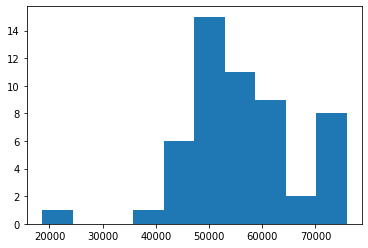

In [0]:
plt.hist(data_stateincome['MedianHHIncome'])

In [0]:
# the data has some outliers, so add a log column
data_stateincome['log_MedianHHIncome'] = np.log(data_stateincome.MedianHHIncome)
data_stateincome.head()

,StateTerritory,MedianHHIncome,log_MedianHHIncome
0,"Washington, D.C.",75628,11.23
1,Maryland,75847,11.24
2,New Jersey,72222,11.19
3,Hawaii,73486,11.20
4,Massachusetts,70628,11.17


In [0]:
data_stateincome.describe()

,MedianHHIncome,log_MedianHHIncome
count,53.00,53.00
mean,55682.00,10.91
std,10678.48,0.22
min,18626.00,9.83
25%,49426.00,10.81
50%,54736.00,10.91
75%,62912.00,11.05
max,75847.00,11.24


### Import data about which cities have the most enthusiastic college sports fans

    * Rank 1 is best
    * This isn't just football. All sports are included. 
    * There are separate ranks for large, medium, and small cities. That means there are three 1s, three 2s, etc. 

In [0]:
# DATA SOURCE: https://wallethub.com/edu/best-sports-cities/15179/

data_fancities = pd.read_csv("/content/drive/My Drive/Colab data HW 1/Best_Sports_Cities.csv"
                    ) 
print(data_fancities.shape)
print(data_fancities.dtypes)
data_fancities.head(13)

(418, 4)
CollFanRank     int64
CityState      object
City           object
State          object
dtype: object


,CollFanRank,CityState,City,State
0,1,"Boston, MA",Boston,MA
1,2,"New York, NY",New York,NY
2,3,"Los Angeles, CA",Los Angeles,CA
3,4,"Pittsburgh, PA",Pittsburgh,PA
4,5,"Philadelphia, PA",Philadelphia,PA
5,6,"Chicago, IL",Chicago,IL
6,7,"Washington, DC",Washington,DC
7,8,"Dallas, TX",Dallas,TX
8,9,"Oakland, CA",Oakland,CA
9,10,"Denver, CO",Denver,CO


In [0]:
fan_nans = data_fancities[data_fancities.isna().any(axis=1)]
print(fan_nans.shape)
fan_nans.head(13)

(0, 4)


,CollFanRank,CityState,City,State


In [0]:
data_fancities['log_CollFanRank'] = np.log(data_fancities['CollFanRank'])
data_fancities.head()

,CollFanRank,CityState,City,State,log_CollFanRank
0,1,"Boston, MA",Boston,MA,0.00
1,2,"New York, NY",New York,NY,0.69
2,3,"Los Angeles, CA",Los Angeles,CA,1.10
3,4,"Pittsburgh, PA",Pittsburgh,PA,1.39
4,5,"Philadelphia, PA",Philadelphia,PA,1.61


### Import data about graduation rates for NCAA schools

* GSR means "graduation success rate"
* FGR means "federal graduation rate"
* The NCAA schools came up with a different way of calculating the graduation rate than the feds, saying the GSR is more accurate

In [0]:
# DATA SOURCE: https://web3.ncaa.org/aprsearch/gsrsearch

data_gradrates = pd.read_csv("/content/drive/My Drive/Colab data HW 1/Graduation_Rates.csv"
                    ) 
print(data_gradrates.shape)
print(data_gradrates.dtypes)
data_gradrates.head(13)

(248, 5)
School         object
Conference     object
State          object
GSR             int64
FGR           float64
dtype: object


,School,Conference,State,GSR,FGR
0,Abilene Christian University,Southland Conference,TX,55,45.00
1,University of Akron,Mid-American Conference,OH,63,56.00
2,Alabama A&M University,Southwestern Athletic Conf.,AL,68,53.00
3,Alabama State University,Southwestern Athletic Conf.,AL,47,37.00
4,University of Alabama,Southeastern Conference,AL,80,62.00
5,University of Alabama at Birmingham,Conference USA,AL,67,55.00
6,University at Albany,Colonial Athletic Association,NY,74,63.00
7,Alcorn State University,Southwestern Athletic Conf.,MS,57,38.00
8,Appalachian State University,Sun Belt Conference,NC,83,80.00
9,Arizona State University,Pac-12 Conference,AZ,80,70.00


In [0]:
data_gradrates.describe()

,GSR,FGR
count,248.00,227.00
mean,72.85,59.83
std,12.41,12.38
min,35.00,31.00
25%,65.75,51.00
50%,73.00,60.00
75%,80.25,67.00
max,99.00,100.00


In [0]:
# check out the blanks for FGR

gradrate_nans = data_gradrates[data_gradrates.isna().any(axis=1)]
print(gradrate_nans)
gradrate_nans.shape

                                  School                    Conference State  \
23                      Brown University                The Ivy League    RI   
27                     Butler University       Pioneer Football League    IN   
34                   Campbell University       Pioneer Football League    NC   
45   Columbia University-Barnard College                The Ivy League    NY   
47                    Cornell University                The Ivy League    NY   
48                     Dartmouth College                The Ivy League    NH   
49                      Davidson College       Pioneer Football League    NC   
53                      Drake University       Pioneer Football League    IA   
70              Georgia State University           Sun Belt Conference    GA   
75                    Harvard University                The Ivy League    MA   
90               Jacksonville University       Pioneer Football League    FL   
123            Morehead State University

(21, 5)

In [0]:
# because FGR is similar to GSR and 1/5 of the values of FGR is missing (it looks like for specific conferences in particular, like the Ivy League)
# I'm going to drop the column after merging the datasets. It would be too difficult to find a fair replacement value.

### Import data about stadium capacity

In [0]:
# DATA SOURCE: https://www.collegegridirons.com/comparisons-by-capacity/
# reference: https://www.geeksforgeeks.org/change-data-type-for-one-or-more-columns-in-pandas-dataframe/

data_stadiums = pd.read_csv("/content/drive/My Drive/Colab data HW 1/Stadium_college.csv"
                           )
print(data_stadiums.shape)
print(data_stadiums.dtypes) 
data_stadiums.head(13)

(131, 4)
Stadium       object
College       object
Conference    object
Capacity       int64
dtype: object


,Stadium,College,Conference,Capacity
0,Michigan Stadium,Michigan,Big Ten,107601
1,Beaver Stadium,Penn State,Big Ten,106572
2,Ohio Stadium,Ohio State,Big Ten,104944
3,Kyle Field,Texas A&M,SEC,102733
4,Neyland Stadium,Tennessee,SEC,102521
5,Bryant Denny Stadium,Alabama,SEC,101821
6,Tiger Stadium,LSU,SEC,100500
7,Royal Memorial Stadium,Texas,Big 12,100119
8,Los Angeles Coliseum,USC,Pac 12,93607
9,Sanford Stadium,Georgia,SEC,92746


(array([13., 26., 17., 16., 18., 15.,  7.,  7.,  4.,  8.]),
 array([ 15000. ,  24260.1,  33520.2,  42780.3,  52040.4,  61300.5,
         70560.6,  79820.7,  89080.8,  98340.9, 107601. ]),
 <a list of 10 Patch objects>)

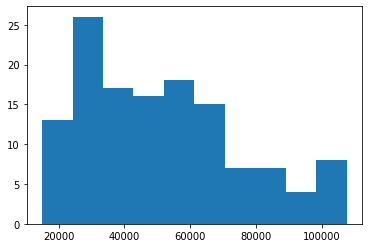

In [0]:
plt.hist(data_stadiums['Capacity'])

In [0]:
data_stadiums['x2_Capacity'] = data_stadiums['Capacity']
data_stadiums['x3_Capacity'] = pow(data_stadiums['Capacity'], 2)
data_stadiums['x4_Capacity'] = pow(data_stadiums['Capacity'], 3)
data_stadiums.head()

,Stadium,College,Conference,Capacity,x2_Capacity,x3_Capacity,x4_Capacity
0,Michigan Stadium,Michigan,Big Ten,107601,107601,11577975201,1245801709602801
1,Beaver Stadium,Penn State,Big Ten,106572,106572,11357591184,1210401207661248
2,Ohio Stadium,Ohio State,Big Ten,104944,104944,11013243136,1155773787664384
3,Kyle Field,Texas A&M,SEC,102733,102733,10554069289,1084251200266837
4,Neyland Stadium,Tennessee,SEC,102521,102521,10510555441,1077552654366761


### Import data about the size of the television media market for each state

* Media markets are more complicated than this. One state could have several markets or one market could contain several states.
* To simplify this, I chose the rank of the biggest media market for each state. 
* 1 is best.

In [0]:
# DATA SOURCE: https://en.wikipedia.org/wiki/List_of_United_States_television_markets

# tv markets by state; list is by counties, I took the highest rank in each state

data_tvmarket = pd.read_csv("/content/drive/My Drive/Colab data HW 1/TV_markets.csv"
                    ) 
print(data_tvmarket.shape)
print(data_tvmarket.dtypes) 
data_tvmarket.head(13)

(42, 2)
TvRank     int64
State     object
dtype: object


,TvRank,State
0,1,New York
1,2,California
2,3,Illinois
3,4,Pennsylvania
4,5,Texas
5,7,District of Columbia
6,9,Massachusetts
7,10,Georgia
8,11,Arizona
9,12,Florida


In [0]:
data_tvmarket['log_TvRank'] = np.log(data_tvmarket['TvRank'])
data_tvmarket.head(3)

,TvRank,State,log_TvRank
0,1,New York,0.00
1,2,California,0.69
2,3,Illinois,1.10


### Import win-loss records and total games played by the school

In [0]:
# DATA SOURCE: https://en.wikipedia.org/wiki/NCAA_Division_I_FBS_football_win-loss_records
# removed several columns from the original, calculated win percentage

data_winpct = pd.read_csv("/content/drive/My Drive/Colab data HW 1/Win_Percent.csv"
                    ) 
print(data_winpct.shape)
print(data_winpct.dtypes)
data_winpct.head(13)


(130, 4)
Team               object
Conference         object
WinPercent        float64
TotGamesPlayed      int64
dtype: object


,Team,Conference,WinPercent,TotGamesPlayed
0,Michigan,Big Ten,0.73,1344
1,Ohio State,Big Ten,0.73,1303
2,Boise State,Mountain West,0.73,632
3,Notre Dame,Independent,0.73,1276
4,Alabama,SEC,0.73,1290
5,Oklahoma,Big 12,0.73,1288
6,Texas,Big 12,0.70,1324
7,Southern California,Pac-12,0.70,1252
8,Nebraska,Big Ten,0.69,1337
9,Penn State,Big Ten,0.69,1332


In [0]:
data_winpct.describe()

,WinPercent,TotGamesPlayed
count,130.00,130.00
mean,0.54,1065.62
std,0.08,308.47
min,0.30,89.00
25%,0.49,1025.25
50%,0.54,1161.50
75%,0.58,1266.75
max,0.73,1361.00


In [0]:
# Rank is largely based on win percent, with the top 25 or so teams getting ranks and the rest getting none
# I'll create a variable for whether a school has a win percent of .60 or higher to approximate that

data_winpct['TopWinners'] = 'False'
data_winpct.loc[data_winpct['WinPercent'] > .60, 'TopWinners'] = 'True'

data_winpct['log_TotGamesPlayed'] = np.log(data_winpct['TotGamesPlayed'])

data_winpct.head()

,Team,Conference,WinPercent,TotGamesPlayed,TopWinners,log_TotGamesPlayed
0,Michigan,Big Ten,0.73,1344,True,7.20
1,Ohio State,Big Ten,0.73,1303,True,7.17
2,Boise State,Mountain West,0.73,632,True,6.45
3,Notre Dame,Independent,0.73,1276,True,7.15
4,Alabama,SEC,0.73,1290,True,7.16


### Import a second rank and win percentage data for 2019...with different rankings

In [0]:
# I ended up not using this because I didn't think it added anything notable

# DATA SOURCE: https://www.sports-reference.com/cfb/years/2018-standings.html

# removed several columns from the original

data_rank = pd.read_csv("/content/drive/My Drive/Colab data HW 1/Rank_WinPct_2019.csv"
                    ) 
print(data_rank.shape)
print(data_rank.dtypes)
data_rank.head(3)

(130, 4)
Rank_2019        int64
School          object
Conf            object
WinPct_2019    float64
dtype: object


,Rank_2019,School,Conf,WinPct_2019
0,1,Clemson,ACC,1.00
1,2,Syracuse,ACC,0.77
2,3,North Carolina State,ACC,0.69


In [0]:
# another option I didn't use
# https://www.nytimes.com/2014/11/08/upshot/the-places-in-america-where-college-football-means-the-most.html
# https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States

## Join datasets, adding columns to the original coach1

This section uses merge and fuzzymatcher to add columns from the new datasets. Merge requires an exact match, and fuzzymatcher picks the closest. I then correct obvious errors by hand and let lesser errors go. 

In [0]:

# reference: https://medium.com/@rtjeannier/combining-data-sets-with-fuzzy-matching-17efcb510ab2
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
# https://www.datacamp.com/community/tutorials/fuzzy-string-python
# http://jonathansoma.com/lede/algorithms-2017/classes/fuzziness-matplotlib/fuzzing-matching-in-pandas-with-fuzzywuzzy/
# https://pypi.org/project/fuzzypanda/
# ended up not using this: uses fuzzywuzzy package: def fuzzy_merge(df_1, df_2, key1, key2, threshold=75, limit=2):
# from https://stackoverflow.com/questions/13636848/is-it-possible-to-do-fuzzy-match-merge-with-python-pandas by Erfan

In [0]:
# Add full name of conference by adding data_confnames
## CREATES coach2
# replaces name of AAC conference by hand because that didn't match

coach2 = coach1
coach2['Conference'] = coach1['Conf_Abbr'].map(data_confnames.set_index('Nicknames')['Conference'])
coach2['Conference'] = np.where(coach2.Conf_Abbr == 'AAC','American Athletic Conference',coach2.Conference)

coach2.head(13)

#reference: https://stackoverflow.com/questions/49161120/pandas-python-set-value-of-one-column-based-on-value-in-another-column

,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference
Air Force,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,50000.00,1476060.00,0,Mountain West Conference
Akron,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00,1500,Mid-American Conference
Alabama,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00,0,Southeastern Conference
Alabama at Birmingham,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00,0,Conference USA
Appalachian State,Appalachian State,Sun Belt,Scott Satterfield,712500,712500,295000.00,145000.00,2160417.00,0,Sun Belt Conference
Arizona,Arizona,Pac-12,Kevin Sumlin,1600000,2000000,2025000.00,279167.00,10000000.00,400000,Pac-12 Conference
Arizona State,Arizona State,Pac-12,Herm Edwards,2000000,2000000,3010000.00,279167.00,8166667.00,0,Pac-12 Conference
Arkansas,Arkansas,SEC,Chad Morris,3500000,3500000,1000000.00,375000.00,12500000.00,0,Southeastern Conference
Arkansas State,Arkansas State,Sun Belt,Blake Anderson,825000,825000,185000.00,25000.00,300000.00,0,Sun Belt Conference
Army,Army,Ind.,Jeff Monken,932521,932521,262500.00,20000.00,916395.00,0,Division I FBS Independents


In [0]:
# I review what each dataset looks like before matching, in order to make sure I'm using the right columns
data_schoolnames.head()

,SchoolFullName,SchoolCommonName,City,State,Primary conference
0,Abilene Christian University,Abilene Christian,Abilene,Texas,Southland Conference
1,University of Akron,Akron,Akron,Ohio,Mid-American Conference
2,University of Alabama,Alabama,Tuscaloosa,Alabama,Southeastern Conference
3,Alabama Agricultural and Mechanical University,Alabama A&M,Huntsville,Alabama,Southwestern Athletic Conference
4,University of Alabama at Birmingham,UAB,Birmingham,Alabama,Conference USA


In [0]:
# Merge coach 2 and data_schoolnames 
# CREATES coach3

# Columns to match on from df_left which is coach2
left_on3 = ["School", "Conference"]

# Columns to match on from df_right which is data_schoolnames
right_on3 = ["SchoolCommonName", "Primary conference"]

# join on the closest match
# fuzzymatcher.fuzzy_left_join(df_left, df_right, left_on, right_on)
coach3 = fuzzy_left_join(coach2, data_schoolnames, left_on3, right_on3)
coach3 = coach3.rename(index=coach3.School)


In [0]:
# the lowest "best match score" are the ones that the fuzzy match algorithm isn't sure about; it's usually right
coach3.sort_values(by=['best_match_score']).head(7)

,best_match_score,__id_left,__id_right,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,Primary conference
Liberty,-0.32,48_left,145_right,Liberty,Ind.,Turner Gill,947281,947281,262500.00,20000.00,916395.00,0,Division I FBS Independents,Liberty University,Liberty,Lynchburg,Virginia,Atlantic Sun Conference[k]
Massachusetts,-0.30,56_left,133_right,Massachusetts,Ind.,Mark Whipple,500000,500000,305000.00,20000.00,300000.00,0,Division I FBS Independents,Jacksonville University,Jacksonville,Jacksonville,Florida,Atlantic Sun Conference[i]
Army,-0.18,9_left,315_right,Army,Ind.,Jeff Monken,932521,932521,262500.00,20000.00,916395.00,0,Division I FBS Independents,United States Military Academy,Army[A 50],West Point,New York,Patriot League[u]
Notre Dame,-0.12,78_left,221_right,Notre Dame,Ind.,Brian Kelly,2129638,2129638,262500.00,20000.00,916395.00,0,Division I FBS Independents,University of Notre Dame,Notre Dame,South Bend,Indiana,Atlantic Coast Conference[q]
Alabama at Birmingham,-0.09,3_left,2_right,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00,0,Conference USA,University of Alabama,Alabama,Tuscaloosa,Alabama,Southeastern Conference
New Mexico State,-0.06,72_left,196_right,New Mexico State,Ind.,Doug Martin,419640,419640,220000.00,20000.00,1532790.00,0,Division I FBS Independents,New Mexico State University,New Mexico State,Las Cruces,New Mexico,Western Athletic Conference[n]
Texas-El Paso,0.07,105_left,212_right,Texas-El Paso,C-USA,Dana Dimel,700000,700000,741665.00,26250.00,2991667.00,0,Conference USA,University of North Texas,North Texas,Denton,Texas,Conference USA


In [0]:

# Fix the worst matches by hand
coach3.sort_values(by=['best_match_score']).head(13)
# Mark Whipple: stints as the University of Massachusetts Amherst (UMass), from 1998 to 2003 and 2014 to 2018. ; in 2015 MAC Mid-American Conference
# Turner Gill: On December 15, 2011, Gill was announced as the new head coach at Liberty University ; Private university in Lynchburg, Virginia; Big South Conference (2002–2017)
# The Army Black Knights football team, previously known as the Army Cadets, represents the United States Military Academy in college football.; 
#   Jeff Monken heads into his sixth season at the helm of Army West Point football in 2019 after being named the 37th individual head coach in program history on Dec. 24, 2013.
# University of Alabama at Birmingham; Public university in Birmingham, Alabama; conference USA
# Texas El Paso, El Paso TX, c-usa,  University of Texas at El Paso (UTEP)
# Texas San Antonio, The UTSA Roadrunners football program represents University of Texas at San Antonio (UTSA) in the sport of American football. 
#   The Roadrunners compete in the Football Bowl Subdivision (FBS) of the National Collegiate Athletic Association (NCAA) and the West Division of Conference USA (CUSA).

coach3.loc['Massachusetts', 'Coach'] = 'Mark Whipple'
coach3.loc['Massachusetts', 'School'] = 'UMass Amherst'
coach3.loc['Massachusetts', 'SchoolFullName'] = 'University of Massachusetts Amherst'
coach3.loc['Massachusetts', 'SchoolCommonName'] = 'UMass'
coach3.loc['Massachusetts', 'City'] = 'Amherst'
coach3.loc['Massachusetts', 'State'] = 'Massachusetts'
coach3.loc['Massachusetts', 'Primary conference'] = 'Division I FBS Independents'
coach3.loc['Alabama at Birmingham', 'SchoolFullName'] = 'University of Alabama at Birmingham'
coach3.loc['Alabama at Birmingham', 'City'] = 'Birmingham'
coach3.loc['Alabama at Birmingham', 'Primary conference'] = 'Conference USA'
coach3.loc['Texas-El Paso', 'SchoolFullName'] = 'University of Texas El Paso'
coach3.loc['Texas-El Paso', 'SchoolCommonName'] = 'UTEP'
coach3.loc['Texas-El Paso', 'City'] = 'El Paso'
coach3.loc['Texas-San Antonio', 'SchoolFullName'] = 'University of Texas San Antonio'
coach3.loc['Texas-San Antonio', 'SchoolCommonName'] = 'UTSA'
coach3.loc['Texas-San Antonio', 'City'] = 'San Antonio'

coach3.sort_values(by=['best_match_score']).head()

# references
# https://stackoverflow.com/questions/46995270/how-set-a-particular-cell-value-in-pandas
# sample: # df.loc[2, 'D1'] = 32
# https://stackoverflow.com/questions/13842088/set-value-for-particular-cell-in-pandas-dataframe-using-index
# sample: df.set_value('C', 'x', 10)
# https://stackoverflow.com/questions/43831539/how-to-select-rows-with-nan-in-particular-column
# sample: #coach3_nans = coach3[coach3['City'].isnull()]
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
# sample: df.sort_values(by=['col1'])


,best_match_score,__id_left,__id_right,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,Primary conference
Liberty,-0.32,48_left,145_right,Liberty,Ind.,Turner Gill,947281,947281,262500.00,20000.00,916395.00,0,Division I FBS Independents,Liberty University,Liberty,Lynchburg,Virginia,Atlantic Sun Conference[k]
Massachusetts,-0.30,56_left,133_right,UMass Amherst,Ind.,Mark Whipple,500000,500000,305000.00,20000.00,300000.00,0,Division I FBS Independents,University of Massachusetts Amherst,UMass,Amherst,Massachusetts,Division I FBS Independents
Army,-0.18,9_left,315_right,Army,Ind.,Jeff Monken,932521,932521,262500.00,20000.00,916395.00,0,Division I FBS Independents,United States Military Academy,Army[A 50],West Point,New York,Patriot League[u]
Notre Dame,-0.12,78_left,221_right,Notre Dame,Ind.,Brian Kelly,2129638,2129638,262500.00,20000.00,916395.00,0,Division I FBS Independents,University of Notre Dame,Notre Dame,South Bend,Indiana,Atlantic Coast Conference[q]
Alabama at Birmingham,-0.09,3_left,2_right,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00,0,Conference USA,University of Alabama at Birmingham,Alabama,Birmingham,Alabama,Conference USA


In [0]:
# remove the match ranking columns
coach3b = coach3.drop(columns=['best_match_score', '__id_left', '__id_right' ])
coach3b.head(3)

,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,Primary conference
Air Force,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,50000.00,1476060.00,0,Mountain West Conference,United States Air Force Academy,Air Force,Colorado Springs,Colorado,Mountain West Conference
Akron,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00,1500,Mid-American Conference,University of Akron,Akron,Akron,Ohio,Mid-American Conference
Alabama,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00,0,Southeastern Conference,University of Alabama,Alabama,Tuscaloosa,Alabama,Southeastern Conference


### Join the state abbreviations data to our dataset

In [0]:
# as a reminder, this is what it looks like
data_stateabbr.head(3)

,StateName,StateAbbr,StateAbbrAlt
0,Alabama,AL,Ala.
1,Alaska,AK,Alaska
2,Arizona,AZ,Ariz.


In [0]:
# Merge coach 3b and data_stateabbr
# CREATES coach4

# Columns to match on from df_left which is coach3b
left_on4 = ["State"]

# Columns to match on from df_right which is data_stateabbr
right_on4 = ["StateName"]

# join on the closest match
# fuzzymatcher.fuzzy_left_join(df_left, df_right, left_on, right_on)
coach4 = fuzzy_left_join(coach3b, data_stateabbr, left_on4, right_on4)

In [0]:
coach4.sort_values(by=['best_match_score']).head(3)

,best_match_score,__id_left,__id_right,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,Primary conference,StateName,StateAbbr,StateAbbrAlt
0,0.12,0_left,5_right,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,50000.00,1476060.00,0,Mountain West Conference,United States Air Force Academy,Air Force,Colorado Springs,Colorado,Mountain West Conference,Colorado,CO,Colo.
87,0.12,85_left,37_right,Oregon State,Pac-12,Jonathan Smith,1900008,1900008,1275000.00,279167.00,4037517.00,0,Pac-12 Conference,Oregon State University,Oregon State,Corvallis,Oregon,Pac-12 Conference,Oregon,OR,Oreg.
86,0.12,84_left,37_right,Oregon,Pac-12,Mario Cristobal,2500000,2500000,1825000.00,279167.00,5208333.00,0,Pac-12 Conference,University of Oregon,Oregon,Eugene,Oregon,Pac-12 Conference,Oregon,OR,Oreg.


In [0]:
# those matches look great, so delete extra columns
coach4b = coach4.drop(columns=['best_match_score', '__id_left', '__id_right'])
coach4b = coach4b.drop(['StateName'], axis=1)
coach4b.head()

,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,Primary conference,StateAbbr,StateAbbrAlt
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,50000.00,1476060.00,0,Mountain West Conference,United States Air Force Academy,Air Force,Colorado Springs,Colorado,Mountain West Conference,CO,Colo.
1,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00,1500,Mid-American Conference,University of Akron,Akron,Akron,Ohio,Mid-American Conference,OH,Ohio
2,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00,0,Southeastern Conference,University of Alabama,Alabama,Tuscaloosa,Alabama,Southeastern Conference,AL,Ala.
3,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00,0,Conference USA,University of Alabama at Birmingham,Alabama,Birmingham,Alabama,Conference USA,AL,Ala.
4,Appalachian State,Sun Belt,Scott Satterfield,712500,712500,295000.00,145000.00,2160417.00,0,Sun Belt Conference,Appalachian State University,Appalachian State,Boone,North Carolina,Sun Belt Conference,NC,N.C.


### Add state median income data to our dataset

In [0]:
# Add state median income via data_stateincome
# CREATE coach5

# a reminder of what the data looks like
data_stateincome.head(3)

,StateTerritory,MedianHHIncome,log_MedianHHIncome
0,"Washington, D.C.",75628,11.23
1,Maryland,75847,11.24
2,New Jersey,72222,11.19


In [0]:
coach5 = coach4b

coach5 = pd.merge(coach5, data_stateincome, how='left', left_on='State', right_on='StateTerritory')
coach5.head()

,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,Primary conference,StateAbbr,StateAbbrAlt,StateTerritory,MedianHHIncome,log_MedianHHIncome
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,50000.00,1476060.00,0,Mountain West Conference,United States Air Force Academy,Air Force,Colorado Springs,Colorado,Mountain West Conference,CO,Colo.,Colorado,63909,11.07
1,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00,1500,Mid-American Conference,University of Akron,Akron,Akron,Ohio,Mid-American Conference,OH,Ohio,Ohio,51075,10.84
2,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00,0,Southeastern Conference,University of Alabama,Alabama,Tuscaloosa,Alabama,Southeastern Conference,AL,Ala.,Alabama,44765,10.71
3,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00,0,Conference USA,University of Alabama at Birmingham,Alabama,Birmingham,Alabama,Conference USA,AL,Ala.,Alabama,44765,10.71
4,Appalachian State,Sun Belt,Scott Satterfield,712500,712500,295000.00,145000.00,2160417.00,0,Sun Belt Conference,Appalachian State University,Appalachian State,Boone,North Carolina,Sun Belt Conference,NC,N.C.,North Carolina,47830,10.78


In [0]:
# check for blanks

coach5_nans = coach5[coach5.isna().any(axis=1)]
print(coach5_nans.shape)
print(coach5_nans)


(0, 20)
Empty DataFrame
Columns: [School, Conf_Abbr, Coach, SchoolPay, TotalPay, Bonus, BonusPaid, Buyout, MediaPay, Conference, SchoolFullName, SchoolCommonName, City, State, Primary conference, StateAbbr, StateAbbrAlt, StateTerritory, MedianHHIncome, log_MedianHHIncome]
Index: []


In [0]:
coach5b = coach5.drop(columns=['StateTerritory'])
coach5b.head()


,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,Primary conference,StateAbbr,StateAbbrAlt,MedianHHIncome,log_MedianHHIncome
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,50000.00,1476060.00,0,Mountain West Conference,United States Air Force Academy,Air Force,Colorado Springs,Colorado,Mountain West Conference,CO,Colo.,63909,11.07
1,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00,1500,Mid-American Conference,University of Akron,Akron,Akron,Ohio,Mid-American Conference,OH,Ohio,51075,10.84
2,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00,0,Southeastern Conference,University of Alabama,Alabama,Tuscaloosa,Alabama,Southeastern Conference,AL,Ala.,44765,10.71
3,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00,0,Conference USA,University of Alabama at Birmingham,Alabama,Birmingham,Alabama,Conference USA,AL,Ala.,44765,10.71
4,Appalachian State,Sun Belt,Scott Satterfield,712500,712500,295000.00,145000.00,2160417.00,0,Sun Belt Conference,Appalachian State University,Appalachian State,Boone,North Carolina,Sun Belt Conference,NC,N.C.,47830,10.78


### Add graduation rates to our dataset

In [0]:
# fuzzy match with data_gradrates
# CREATES coach6


#as a reminder, this is what the data looks like
data_gradrates.head(3)

,School,Conference,State,GSR,FGR
0,Abilene Christian University,Southland Conference,TX,55,45.00
1,University of Akron,Mid-American Conference,OH,63,56.00
2,Alabama A&M University,Southwestern Athletic Conf.,AL,68,53.00


In [0]:
# Merge coach5b and data_gradrates

# Columns to match on from df_left which is coach5
left_on6 = ["SchoolFullName", "Conference", "StateAbbr"]

# Columns to match on from df_right which is data_gradrates
right_on6 = ["School", "Conference", "State"]

# join on the closest match
# fuzzymatcher.fuzzy_left_join(df_left, df_right, left_on, right_on)
coach6 = fuzzy_left_join(coach5b, data_gradrates, left_on6, right_on6)

In [0]:
coach6.sort_values(by=['best_match_score']).head(7)

,best_match_score,__id_left,__id_right,School_left,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference_left,SchoolFullName,SchoolCommonName,City,State_left,Primary conference,StateAbbr,StateAbbrAlt,MedianHHIncome,log_MedianHHIncome,School_right,Conference_right,State_right,GSR,FGR
9,-0.07,9_left,216_right,Army,Ind.,Jeff Monken,932521,932521,262500.00,20000.00,916395.00,0,Division I FBS Independents,United States Military Academy,Army[A 50],West Point,New York,Patriot League[u],NY,N.Y.,60850,11.02,U.S. Military Academy,Independent,NY,84,nan
65,-0.05,48_left,99_right,Liberty,Ind.,Turner Gill,947281,947281,262500.00,20000.00,916395.00,0,Division I FBS Independents,Liberty University,Liberty,Lynchburg,Virginia,Atlantic Sun Conference[k],VA,Va.,66262,11.10,Liberty University,Big South Conference,VA,75,65.00
32,0.06,19_left,126_right,Charlotte,C-USA,Brad Lambert,625000,625000,120000.00,0.00,556389.00,0,Conference USA,University of North Carolina at Charlotte,Charlotte,Charlotte,North Carolina,Conference USA,NC,N.C.,47830,10.78,"University of North Carolina, Chapel Hill",Atlantic Coast Conference,NC,59,46.00
133,0.24,56_left,107_right,UMass Amherst,Ind.,Mark Whipple,500000,500000,305000.00,20000.00,300000.00,0,Division I FBS Independents,University of Massachusetts Amherst,UMass,Amherst,Massachusetts,Division I FBS Independents,MA,Mass.,70628,11.17,"University of Massachusetts, Amherst",Mid-American Conference,MA,62,52.00
150,0.26,72_left,131_right,New Mexico State,Ind.,Doug Martin,419640,419640,220000.00,20000.00,1532790.00,0,Division I FBS Independents,New Mexico State University,New Mexico State,Las Cruces,New Mexico,Western Athletic Conference[n],NM,N. Mex.,45382,10.72,New Mexico State University,Sun Belt Conference,NM,66,59.00
35,0.27,22_left,41_right,Coastal Carolina,Sun Belt,Joe Moglia,400000,400000,800000.00,25000.00,516667.00,0,Sun Belt Conference,Coastal Carolina University,Coastal Carolina,Conway,South Carolina,Sun Belt Conference,SC,S.C.,47238,10.76,Coastal Carolina University,Big South Conference,SC,71,63.00
195,0.29,116_left,225_right,Virginia Tech,ACC,Justin Fuente,4000000,4000000,435000.00,75000.00,15000000.00,0,Atlantic Coast Conference,Virginia Tech[A 52],Virginia Tech,Blacksburg,Virginia,Atlantic Coast Conference,VA,Va.,66262,11.10,University of Virginia,Atlantic Coast Conference,VA,77,70.00


In [0]:
coach6b = coach6.drop(columns=['best_match_score', '__id_left', '__id_right'])
coach6b = coach6b.drop(columns=['Primary conference', 'StateAbbrAlt', 'School_right', 'Conference_right', 'State_right', 'FGR'])
coach6b = coach6b.rename(columns={"School_left": "School", "Conference_left": "Conference", "State_left": "State"})
coach6b.head()

,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,StateAbbr,MedianHHIncome,log_MedianHHIncome,GSR
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,50000.00,1476060.00,0,Mountain West Conference,United States Air Force Academy,Air Force,Colorado Springs,Colorado,CO,63909,11.07,82
1,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00,1500,Mid-American Conference,University of Akron,Akron,Akron,Ohio,OH,51075,10.84,63
2,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00,0,Southeastern Conference,University of Alabama,Alabama,Tuscaloosa,Alabama,AL,44765,10.71,80
3,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00,0,Conference USA,University of Alabama at Birmingham,Alabama,Birmingham,Alabama,AL,44765,10.71,67
4,Appalachian State,Sun Belt,Scott Satterfield,712500,712500,295000.00,145000.00,2160417.00,0,Sun Belt Conference,Appalachian State University,Appalachian State,Boone,North Carolina,NC,47830,10.78,83


### Add in the college stadium capacity

In [0]:
# reminder of what the stadium data looks like
data_stadiums.head(3)

,Stadium,College,Conference,Capacity,x2_Capacity,x3_Capacity,x4_Capacity
0,Michigan Stadium,Michigan,Big Ten,107601,107601,11577975201,1245801709602801
1,Beaver Stadium,Penn State,Big Ten,106572,106572,11357591184,1210401207661248
2,Ohio Stadium,Ohio State,Big Ten,104944,104944,11013243136,1155773787664384


In [0]:
# Merge coach6 and data_stadiums
# CREATES coach7


# Columns to match on from df_left which is coach5
left_on7 = ["School", "Conf_Abbr"]

# Columns to match on from df_right which is data_stadiums
right_on7 = ["College", "Conference"]

# join on the closest match
# fuzzymatcher.fuzzy_left_join(df_left, df_right, left_on, right_on)
coach7 = fuzzy_left_join(coach6b, data_stadiums, left_on7, right_on7)

In [0]:
coach7.sort_values(by=['best_match_score']).head(7)

,best_match_score,__id_left,__id_right,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference_left,SchoolFullName,SchoolCommonName,City,State,StateAbbr,MedianHHIncome,log_MedianHHIncome,GSR,Stadium,College,Conference_right,Capacity,x2_Capacity,x3_Capacity,x4_Capacity
3,-0.13,3_left,5_right,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00,0,Conference USA,University of Alabama at Birmingham,Alabama,Birmingham,Alabama,AL,44765,10.71,67,Bryant Denny Stadium,Alabama,SEC,101821,101821,10367516041,1055630850810661
65,-0.03,48_left,127_right,Liberty,Ind.,Turner Gill,947281,947281,262500.00,20000.00,916395.00,0,Division I FBS Independents,Liberty University,Liberty,Lynchburg,Virginia,VA,66262,11.10,75,McGuirk Stadium,UMass,Ind.,17000,17000,289000000,4913000000000
92,0.04,70_left,110_right,Nevada-Las Vegas,Mt. West,Tony Sanchez,600000,600000,260000.00,0.00,950000.00,0,Mountain West Conference,"University of Nevada, Reno",Nevada,Reno,Nevada,NV,52431,10.87,69,MacKay Stadium,Nevada,Mountain West,29993,29993,899580049,26981104409657
204,0.04,105_left,97_right,Texas-El Paso,C-USA,Dana Dimel,700000,700000,741665.00,26250.00,2991667.00,0,Conference USA,University of Texas El Paso,UTEP,El Paso,Texas,TX,55653,10.93,70,Apogee Stadium,North Texas,C-USA,30850,30850,951722500,29360639125000
205,0.05,106_left,97_right,Texas-San Antonio,C-USA,Frank Wilson,1100000,1100000,185000.00,17500.00,3562500.00,0,Conference USA,University of Texas San Antonio,UTSA,San Antonio,Texas,TX,55653,10.93,86,Apogee Stadium,North Texas,C-USA,30850,30850,951722500,29360639125000
200,0.12,102_left,7_right,Texas Christian,Big 12,Gary Patterson,4840717,4840717,825000.00,68750.00,11283334.00,0,Big 12 Conference,University of Texas at Austin,Texas,Austin,Texas,TX,55653,10.93,58,Royal Memorial Stadium,Texas,Big 12,100119,100119,10023814161,1003574249985159
78,0.13,58_left,32_right,Miami (Fla.),ACC,Mark Richt,4058061,4058061,1340000.00,225000.00,14528125.00,0,Atlantic Coast Conference,University of Miami,Miami (FL)[A 22],Coral Gables,Florida,FL,49426,10.81,86,Hard Rock Stadium,Miami,ACC,65236,65236,4255735696,277627173864256


In [0]:
# fix two errors by hand; these were not in the stadium dataset
# Liberty University stadium capacity 25000: https://en.wikipedia.org/wiki/Williams_Stadium
# Alabama at Birmingham stadium capacity 83091: https://en.wikipedia.org/wiki/Legion_Field

coach7.loc[3, 'Capacity'] = 83091
coach7.loc[65, 'Capacity'] = 25000
coach7.sort_values(by=['best_match_score']).head(3)

,best_match_score,__id_left,__id_right,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference_left,SchoolFullName,SchoolCommonName,City,State,StateAbbr,MedianHHIncome,log_MedianHHIncome,GSR,Stadium,College,Conference_right,Capacity,x2_Capacity,x3_Capacity,x4_Capacity
3,-0.13,3_left,5_right,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00,0,Conference USA,University of Alabama at Birmingham,Alabama,Birmingham,Alabama,AL,44765,10.71,67,Bryant Denny Stadium,Alabama,SEC,83091,101821,10367516041,1055630850810661
65,-0.03,48_left,127_right,Liberty,Ind.,Turner Gill,947281,947281,262500.00,20000.00,916395.00,0,Division I FBS Independents,Liberty University,Liberty,Lynchburg,Virginia,VA,66262,11.10,75,McGuirk Stadium,UMass,Ind.,25000,17000,289000000,4913000000000
92,0.04,70_left,110_right,Nevada-Las Vegas,Mt. West,Tony Sanchez,600000,600000,260000.00,0.00,950000.00,0,Mountain West Conference,"University of Nevada, Reno",Nevada,Reno,Nevada,NV,52431,10.87,69,MacKay Stadium,Nevada,Mountain West,29993,29993,899580049,26981104409657


In [0]:
coach7b = coach7.drop(columns=['best_match_score', '__id_left', '__id_right'])
coach7b = coach7b.drop(columns=['Conference_right', 'Stadium', 'College'])
coach7b = coach7b.rename(columns={"Conference_left": "Conference"})
coach7b.head(3)

,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,StateAbbr,MedianHHIncome,log_MedianHHIncome,GSR,Capacity,x2_Capacity,x3_Capacity,x4_Capacity
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,50000.00,1476060.00,0,Mountain West Conference,United States Air Force Academy,Air Force,Colorado Springs,Colorado,CO,63909,11.07,82,52237,52237,2728704169,142539319676053
1,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00,1500,Mid-American Conference,University of Akron,Akron,Akron,Ohio,OH,51075,10.84,63,30000,30000,900000000,27000000000000
2,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00,0,Southeastern Conference,University of Alabama,Alabama,Tuscaloosa,Alabama,AL,44765,10.71,80,101821,101821,10367516041,1055630850810661


### Add in the win percent data

In [0]:
# a reminder of what the data looks like
data_winpct.head(3)

,Team,Conference,WinPercent,TotGamesPlayed,TopWinners,log_TotGamesPlayed
0,Michigan,Big Ten,0.73,1344,True,7.20
1,Ohio State,Big Ten,0.73,1303,True,7.17
2,Boise State,Mountain West,0.73,632,True,6.45


In [0]:
# Merge coach7b and data_winpct
# CREATES coach8


# Columns to match on from df_left which is coach7b
left_on8 = ["School", "Conf_Abbr"]

# Columns to match on from df_right which is data_winpct
right_on8 = ["Team", "Conference"]

# join on the closest match
# fuzzymatcher.fuzzy_left_join(df_left, df_right, left_on, right_on)
coach8 = fuzzy_left_join(coach7b, data_winpct, left_on8, right_on8)

In [0]:
coach8.sort_values(by=['best_match_score']).head(7)

,best_match_score,__id_left,__id_right,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference_left,SchoolFullName,SchoolCommonName,City,State,StateAbbr,MedianHHIncome,log_MedianHHIncome,GSR,Capacity,x2_Capacity,x3_Capacity,x4_Capacity,Team,Conference_right,WinPercent,TotGamesPlayed,TopWinners,log_TotGamesPlayed
3,-0.14,3_left,4_right,Alabama at Birmingham,C-USA,Bill Clark,900000,900000,950000.00,165471.00,3847500.00,0,Conference USA,University of Alabama at Birmingham,Alabama,Birmingham,Alabama,AL,44765,10.71,67,83091,101821,10367516041,1055630850810661,Alabama,SEC,0.73,1290.00,True,7.16
92,0.01,67_left,55_right,Navy,AAC,Ken Niumatalolo,2163000,2163000,775000.00,45000.00,2112500.00,0,American Athletic Conference,University of Houston,Houston,Houston,Texas,TX,55653,10.93,58,34000,34000,1156000000,39304000000000,Navy,The American,0.56,1349.00,False,7.21
61,0.03,39_left,66_right,Houston,AAC,Major Applewhite,1750000,1750000,782500.00,20000.00,2112500.00,0,American Athletic Conference,University of Houston,Houston,Houston,Texas,TX,55653,10.93,58,40000,40000,1600000000,64000000000000,Houston,The American,0.54,834.00,False,6.73
42,0.03,20_left,79_right,Cincinnati,AAC,Luke Fickell,2000000,2000000,625000.00,0.00,7100000.00,0,American Athletic Conference,University of Cincinnati,Cincinnati,Cincinnati,Ohio,OH,51075,10.84,74,40000,40000,1600000000,64000000000000,Cincinnati,The American,0.51,1268.00,False,7.15
162,0.03,109_left,111_right,Tulane,AAC,Willie Fritz,1629000,1629000,775000.00,45000.00,2112500.00,0,American Athletic Conference,Tulane University,Tulane,New Orleans,Louisiana,LA,45727,10.73,87,30000,30000,900000000,27000000000000,Tulane,The American,0.45,1223.00,False,7.11
163,0.03,110_left,61_right,Tulsa,AAC,Philip Montgomery,1518177,1518177,775000.00,45000.00,2112500.00,0,American Athletic Conference,University of Tulsa,Tulsa,Tulsa,Oklahoma,OK,48568,10.79,71,35542,35542,1263233764,44897854440088,Tulsa,The American,0.55,1162.00,False,7.06
81,0.03,57_left,96_right,Memphis,AAC,Mike Norvell,2600000,2600000,775000.00,185000.00,7431667.00,0,American Athletic Conference,University of Memphis,Memphis,Memphis,Tennessee,TN,47275,10.76,71,62380,62380,3891264400,242737073272000,Memphis,The American,0.49,1054.00,False,6.96


In [0]:
# several sources do not list the UAB Blazers win percentage for 2015, so I'm going to let it go: https://en.wikipedia.org/wiki/List_of_UAB_Blazers_football_seasons

coach8b = coach8.drop(columns=['best_match_score', '__id_left', '__id_right'])
coach8b = coach8b.drop(columns=['Conference_right'])
coach8b = coach8b.rename(columns={"Conference_left": "Conference"})
coach8b.head(3)

,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,StateAbbr,MedianHHIncome,log_MedianHHIncome,GSR,Capacity,x2_Capacity,x3_Capacity,x4_Capacity,Team,WinPercent,TotGamesPlayed,TopWinners,log_TotGamesPlayed
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,50000.00,1476060.00,0,Mountain West Conference,United States Air Force Academy,Air Force,Colorado Springs,Colorado,CO,63909,11.07,82,52237,52237,2728704169,142539319676053,Air Force,0.55,743.00,False,6.61
1,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00,1500,Mid-American Conference,University of Akron,Akron,Akron,Ohio,OH,51075,10.84,63,30000,30000,900000000,27000000000000,Akron,0.48,1117.00,False,7.02
2,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00,0,Southeastern Conference,University of Alabama,Alabama,Tuscaloosa,Alabama,AL,44765,10.71,80,101821,101821,10367516041,1055630850810661,Alabama,0.73,1290.00,True,7.16


### Add in the rank of the cities by their fan support of college sports


In [0]:
# a reminder of what the fan data looks like
# there is a 1 for large cities, a 1 for medium cities, and a 1 for small cities, etc. 
data_fancities.head()

,CollFanRank,CityState,City,State,log_CollFanRank
0,1,"Boston, MA",Boston,MA,0.00
1,2,"New York, NY",New York,NY,0.69
2,3,"Los Angeles, CA",Los Angeles,CA,1.10
3,4,"Pittsburgh, PA",Pittsburgh,PA,1.39
4,5,"Philadelphia, PA",Philadelphia,PA,1.61


In [0]:
# Merge coach8b and data_fancities
# CREATES coach9


# Columns to match on from df_left which is coach8b
left_on9 = ["City", "State"]

# Columns to match on from df_right which is data_fancities
right_on9 = ["City", "State"]

# join on the closest match
# fuzzymatcher.fuzzy_left_join(df_left, df_right, left_on, right_on)
coach9 = fuzzy_left_join(coach8b, data_fancities, left_on9, right_on9)

In [0]:
coach9.sort_values(by=['best_match_score']).head(7)

,best_match_score,__id_left,__id_right,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City_left,State_left,StateAbbr,MedianHHIncome,log_MedianHHIncome,GSR,Capacity,x2_Capacity,x3_Capacity,x4_Capacity,Team,WinPercent,TotGamesPlayed,TopWinners,log_TotGamesPlayed,CollFanRank,CityState,City_right,State_right,log_CollFanRank
75,-0.11,63_left,13_right,Minnesota,Big Ten,P.J. Fleck,3550000,3550000,900000.00,0.00,9291667.00,0,Big Ten Conference,University of Minnesota,Minnesota,Minneapolis–Saint Paul,Minnesota,MN,63488,11.06,71,50805,50805,2581148025,131135225410125,Minnesota,0.57,1273.00,False,7.15,14.00,"Minneapolis, MN",Minneapolis,MN,2.64
15,-0.10,13_left,309_right,Boston College,ACC,Steve Addazio,2514859,2514859,1340000.00,225000.00,14528125.00,0,Atlantic Coast Conference,Boston College,Boston College,Chestnut Hill,Massachusetts,MA,70628,11.17,90,44500,44500,1980250000,88121125000000,Boston College,0.57,1208.00,False,7.10,142.00,"Rock Hill, SC",Rock Hill,SC,4.96
85,-0.00,71_left,42_right,New Mexico,Mt. West,Bob Davie,822690,823740,340000.00,0.00,1303294.00,1050,Mountain West Conference,University of New Mexico,New Mexico,Albuquerque,New Mexico,NM,45382,10.72,65,39224,39224,1538522176,60346993831424,New Mexico,0.45,1127.00,False,7.03,43.00,"Albuquerque, NM",Albuquerque,NM,3.76
137,0.01,120_left,174_right,West Virginia,Big 12,Dana Holgorsen,3605000,3617500,1000000.00,90000.00,7150000.00,12500,Big 12 Conference,West Virginia University,West Virginia,Morgantown,West Virginia,WV,42019,10.65,67,60000,60000,3600000000,216000000000000,West Virginia,0.60,1304.00,False,7.17,7.00,"Morgantown, WV",Morgantown,WV,1.95
65,0.01,54_left,206_right,Marshall,C-USA,Doc Holliday,762570,762570,145000.00,55000.00,1951708.00,0,Conference USA,Marshall University,Marshall,Huntington,West Virginia,WV,42019,10.65,70,38019,38019,1445444361,54954349160859,Marshall,0.52,1197.00,False,7.09,39.00,"Huntington, WV",Huntington,WV,3.66
27,0.01,22_left,264_right,Coastal Carolina,Sun Belt,Joe Moglia,400000,400000,800000.00,25000.00,516667.00,0,Sun Belt Conference,Coastal Carolina University,Coastal Carolina,Conway,South Carolina,SC,47238,10.76,71,15000,15000,225000000,3375000000000,Coastal Carolina,0.62,204.00,True,5.32,97.00,"Conway, SC",Conway,SC,4.57
108,0.01,93_left,96_right,South Carolina,SEC,Will Muschamp,4200000,4200000,1400000.00,100000.00,18650000.00,0,Southeastern Conference,University of South Carolina,South Carolina,Columbia,South Carolina,SC,47238,10.76,95,80250,80250,6440062500,516815015625000,South Carolina,0.51,1243.00,False,7.13,37.00,"Columbia, SC",Columbia,SC,3.61


In [0]:
# Chestnut Hill, MA wasn't in the dataset for fan rank, so Boston College was mislabeled with a rank of 142 intead of 1 (Boston)
coach9.loc[15, 'CollFanRank'] = 1

coach9b = coach9.drop(columns=['best_match_score', '__id_left', '__id_right'])
coach9b = coach9b.drop(columns=['CityState', 'City_right', 'State_right', 'Team'])
coach9b = coach9b.rename(columns={"City_left": "City", "State_left":"State"})
coach9b.head(3)

,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,StateAbbr,MedianHHIncome,log_MedianHHIncome,GSR,Capacity,x2_Capacity,x3_Capacity,x4_Capacity,WinPercent,TotGamesPlayed,TopWinners,log_TotGamesPlayed,CollFanRank,log_CollFanRank
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,50000.00,1476060.00,0,Mountain West Conference,United States Air Force Academy,Air Force,Colorado Springs,Colorado,CO,63909,11.07,82,52237,52237,2728704169,142539319676053,0.55,743.00,False,6.61,42.00,3.74
1,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00,1500,Mid-American Conference,University of Akron,Akron,Akron,Ohio,OH,51075,10.84,63,30000,30000,900000000,27000000000000,0.48,1117.00,False,7.02,48.00,3.87
2,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00,0,Southeastern Conference,University of Alabama,Alabama,Tuscaloosa,Alabama,AL,44765,10.71,80,101821,101821,10367516041,1055630850810661,0.73,1290.00,True,7.16,5.00,1.61


### Add data on the rank of the tv/media market

In [0]:
# reminder of what data_tvmarket looks like; this is state-level data (which is an approximation of how markets are organized)
data_tvmarket.head(3)

,TvRank,State,log_TvRank
0,1,New York,0.00
1,2,California,0.69
2,3,Illinois,1.10


In [0]:
# Merge coach9b and data_tvmarket
# CREATES coach10


# Columns to match on from df_left which is coach9b
left_on10 = ["State"]

# Columns to match on from df_right which is data_tvmarket
right_on10 = ["State"]

# join on the closest match
# fuzzymatcher.fuzzy_left_join(df_left, df_right, left_on, right_on)
coach10 = fuzzy_left_join(coach9b, data_tvmarket, left_on10, right_on10)

In [0]:
coach10.sort_values(by=['best_match_score']).head(7)

,best_match_score,__id_left,__id_right,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State_left,StateAbbr,MedianHHIncome,log_MedianHHIncome,GSR,Capacity,x2_Capacity,x3_Capacity,x4_Capacity,WinPercent,TotGamesPlayed,TopWinners,log_TotGamesPlayed,CollFanRank,log_CollFanRank,TvRank,State_right,log_TvRank
91,0.02,89_left,0_right,Rutgers,Big Ten,Chris Ash,2200000,2200000,960000.00,50000.00,10350000.00,0,Big Ten Conference,Rutgers University,Rutgers,New Brunswick,New Jersey,NJ,72222,11.19,82,52454,52454,2751422116,144323095672664,0.49,1361.00,False,7.22,140.00,4.94,1.00,New York,0.00
88,0.12,86_left,3_right,Penn State,Big Ten,James Franklin,4800000,4800000,1000000.00,300000.00,18375000.00,0,Big Ten Conference,Pennsylvania State University,Penn State,State College,Pennsylvania,PA,55702,10.93,80,106572,106572,11357591184,1210401207661248,0.69,1332.00,True,7.19,3.00,1.10,4.00,Pennsylvania,1.39
87,0.12,85_left,16_right,Oregon State,Pac-12,Jonathan Smith,1900008,1900008,1275000.00,279167.00,4037517.00,0,Pac-12 Conference,Oregon State University,Oregon State,Corvallis,Oregon,OR,54148,10.90,72,45674,45674,2086114276,95281183442024,0.47,1197.00,False,7.09,118.00,4.77,22.00,Oregon,3.09
86,0.12,84_left,16_right,Oregon,Pac-12,Mario Cristobal,2500000,2500000,1825000.00,279167.00,5208333.00,0,Pac-12 Conference,University of Oregon,Oregon,Eugene,Oregon,OR,54148,10.90,68,54000,54000,2916000000,157464000000000,0.57,1214.00,False,7.10,19.00,2.94,22.00,Oregon,3.09
83,0.12,82_left,27_right,Oklahoma State,Big 12,Mike Gundy,5000000,5000000,900000.00,62500.00,16250000.00,0,Big 12 Conference,Oklahoma State University–Stillwater,Oklahoma State,Stillwater,Oklahoma,OK,48568,10.79,50,60218,60218,3626207524,218362964680232,0.52,1205.00,False,7.09,15.00,2.71,43.00,Oklahoma,3.76
82,0.12,81_left,27_right,Oklahoma,Big 12,Lincoln Riley,4800000,4800000,700000.00,180000.00,20833333.00,0,Big 12 Conference,University of Oklahoma,Oklahoma,Norman,Oklahoma,OK,48568,10.79,76,84000,84000,7056000000,592704000000000,0.73,1288.00,True,7.16,13.00,2.56,43.00,Oklahoma,3.76
81,0.12,80_left,14_right,Ohio State,Big Ten,Urban Meyer,7600000,7600000,775000.00,350000.00,38058402.00,0,Big Ten Conference,The Ohio State University,Ohio State[A 33],Columbus,Ohio,OH,51075,10.84,74,104944,104944,11013243136,1155773787664384,0.73,1303.00,True,7.17,31.00,3.43,19.00,Ohio,2.94


In [0]:

coach10b = coach10.drop(columns=['best_match_score', '__id_left', '__id_right'])
coach10b = coach10b.drop(columns=['State_right'])
coach10b = coach10b.rename(columns={"State_left":"State"})
coach10b.head(3)

,School,Conf_Abbr,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,Buyout,MediaPay,Conference,SchoolFullName,SchoolCommonName,City,State,StateAbbr,MedianHHIncome,log_MedianHHIncome,GSR,Capacity,x2_Capacity,x3_Capacity,x4_Capacity,WinPercent,TotGamesPlayed,TopWinners,log_TotGamesPlayed,CollFanRank,log_CollFanRank,TvRank,log_TvRank
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000.00,50000.00,1476060.00,0,Mountain West Conference,United States Air Force Academy,Air Force,Colorado Springs,Colorado,CO,63909,11.07,82,52237,52237,2728704169,142539319676053,0.55,743.00,False,6.61,42.00,3.74,17.00,2.83
1,Akron,MAC,Terry Bowden,411000,412500,225000.00,50000.00,688500.00,1500,Mid-American Conference,University of Akron,Akron,Akron,Ohio,OH,51075,10.84,63,30000,30000,900000000,27000000000000,0.48,1117.00,False,7.02,48.00,3.87,19.00,2.94
2,Alabama,SEC,Nick Saban,8307000,8307000,1100000.00,500000.00,33600000.00,0,Southeastern Conference,University of Alabama,Alabama,Tuscaloosa,Alabama,AL,44765,10.71,80,101821,101821,10367516041,1055630850810661,0.73,1290.00,True,7.16,5.00,1.61,44.00,3.78


### Save a copy of all the columns

In [0]:
# save this dataset in a file so I don't have to load and munge everything above every time I work on this

coach10b.to_csv(r'/content/drive/My Drive/Colab data HW 1/coach_newcolumns.csv', index = False)

# Models and evaluation

## Decide which columns to keep for the models

Looking at the correlation matrix for the fields:

* There is a strong correlation between the pay related numbers. It doesn't help to keep all of them. Maybe try with just TotalPay and Buyout.
* Some of the new fields show some differences, such as MedianHHIncome, CollFankRank, and TvRank.
* GSR, WinPercent, and Capacity all look useful. 
* I'm going to remove SchoolPay, Bonus, BonusPaid, and TotGamesPlayed. 
* The transformations I tried did not seem to work at all. Gosh darn it. 


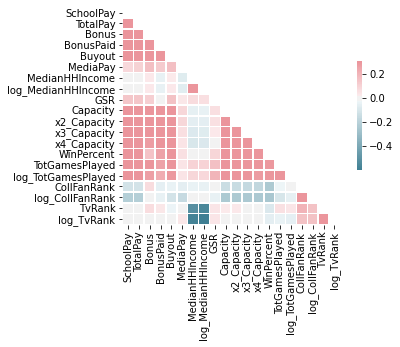

In [0]:
corr1 = coach10b.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [0]:
#print(coach10b.head(2))


modelDF_1 = coach10b[['SchoolFullName', 'Conf_Abbr', 'GSR', 'x4_Capacity', 'WinPercent', 'TopWinners', 'MediaPay', 'StateAbbr', 'MedianHHIncome', 'CollFanRank', 'TvRank', 'SchoolPay']]
modelDF_1.head()

# reference: https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns
# sample: df = df[['mean', 4,3,2,1]]

,SchoolFullName,Conf_Abbr,GSR,x4_Capacity,WinPercent,TopWinners,MediaPay,StateAbbr,MedianHHIncome,CollFanRank,TvRank,SchoolPay
0,United States Air Force Academy,Mt. West,82,142539319676053,0.55,False,0,CO,63909,42.00,17.00,885000
1,University of Akron,MAC,63,27000000000000,0.48,False,1500,OH,51075,48.00,19.00,411000
2,University of Alabama,SEC,80,1055630850810661,0.73,True,0,AL,44765,5.00,44.00,8307000
3,University of Alabama at Birmingham,C-USA,67,1055630850810661,0.73,True,0,AL,44765,15.00,44.00,900000
4,Appalachian State University,Sun Belt,83,14084823375000,0.65,True,0,NC,47830,18.00,21.00,712500


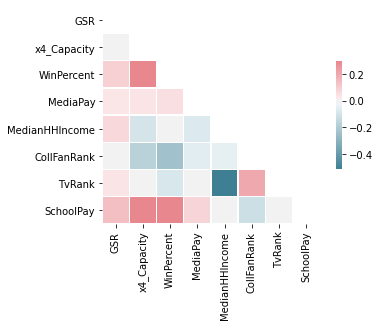

In [0]:
# show the correlation of remaining columns
corr2 = modelDF_1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Linear regression models

In [0]:
modelDF_1.columns

Index(['SchoolFullName', 'Conf_Abbr', 'GSR', 'x4_Capacity', 'WinPercent',
       'TopWinners', 'MediaPay', 'StateAbbr', 'MedianHHIncome', 'CollFanRank',
       'TvRank', 'SchoolPay'],
      dtype='object')

In [0]:
# one more check for any blanks
model1_nans = modelDF_1[modelDF_1.isna().any(axis=1)]
print(model1_nans.shape)
model1_nans.head(13)

(6, 12)


,SchoolFullName,Conf_Abbr,GSR,x4_Capacity,WinPercent,TopWinners,MediaPay,StateAbbr,MedianHHIncome,CollFanRank,TvRank,SchoolPay
12,Boise State University,Mt. West,85,50653000000000,0.73,True,0,ID,48275,21.00,nan,1650010
25,University of Houston,AAC,58,64000000000000,nan,NaN,0,TX,55653,15.00,5.00,1100000
38,"University of Nevada, Las Vegas",Mt. West,51,125000000000000,0.55,False,61500,NV,52431,nan,39.00,425004
57,University of Massachusetts Amherst,Ind.,62,4913000000000,nan,NaN,0,MA,70628,32.00,9.00,500000
100,Stanford University,Pac-12,99,125000000000000,0.58,False,0,CA,64500,nan,2.00,4311543
129,University of Wyoming,Mt. West,73,24848519136741,0.48,False,0,WY,60214,112.00,nan,1412000


In [0]:
# filling in NaNs with real values or approximations when those aren't available

modelDF_1.loc[12, 'TvRank'] = 100
modelDF_1.loc[129, 'TvRank'] = 100
modelDF_1.loc[38, 'CollFanRank'] = 35
modelDF_1.loc[100, 'CollFanRank'] = 20 # Palo Alto isn't in list, use San Francisco
modelDF_1.loc[25, 'TopWinners'] = 'False'
modelDF_1.loc[57, 'TopWinners'] = 'False'
modelDF_1.loc[25, 'WinPercent'] = .50  # don't have data for these two schools so putting in 50% win/loss
modelDF_1.loc[57, 'WinPercent'] = .50

model1_nans = modelDF_1[modelDF_1.isna().any(axis=1)]
print(model1_nans.shape)
model1_nans.head(13)

(0, 12)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,SchoolFullName,Conf_Abbr,GSR,x4_Capacity,WinPercent,TopWinners,MediaPay,StateAbbr,MedianHHIncome,CollFanRank,TvRank,SchoolPay


In [0]:
syr_row = modelDF_1.loc[modelDF_1['SchoolFullName'] == 'Syracuse University']
syr_row

,SchoolFullName,Conf_Abbr,GSR,x4_Capacity,WinPercent,TopWinners,MediaPay,StateAbbr,MedianHHIncome,CollFanRank,TvRank,SchoolPay,runiform
101,Syracuse University,ACC,80,119458953125000,0.57,False,0,NY,60850,40.00,1.00,2401206,0.08


### Linear model 1: all variables

In [0]:
# use training-and-test regimen for model validation
np.random.seed(609)
modelDF_1['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(modelDF_1))
modelDF_1_train = modelDF_1[modelDF_1['runiform'] >= 0.33]
modelDF_1_test = modelDF_1[modelDF_1['runiform'] < 0.33]
# check training data frame
print('\nmodelDF_1_train data frame (rows, columns): ',modelDF_1_train.shape)
print(modelDF_1_train.head())
# check test data frame
print('\nmodelDF_1_test data frame (rows, columns): ',modelDF_1_test.shape)
print(modelDF_1_test.head(3))

# start with a simple model
# was "my_model"
model1 = str('SchoolPay ~ Conf_Abbr + GSR + x4_Capacity + WinPercent + TopWinners + MediaPay + MedianHHIncome + CollFanRank + TvRank')

# fit the model to the training set
train_model1_fit = smf.ols(model1, data = modelDF_1_train).fit()
# summary of model fit to the training set
print(train_model1_fit.summary())
# training set predictions from the model fit to the training set
modelDF_1_train['predict_schoolpay'] = train_model1_fit.fittedvalues

# test set predictions from the model fit to the training set
modelDF_1_test['predict_schoolpay'] = train_model1_fit.predict(modelDF_1_test)



modelDF_1_train data frame (rows, columns):  (82, 13)
                        SchoolFullName Conf_Abbr  GSR       x4_Capacity  \
0      United States Air Force Academy  Mt. West   82   142539319676053   
2                University of Alabama       SEC   80  1055630850810661   
3  University of Alabama at Birmingham     C-USA   67  1055630850810661   
4         Appalachian State University  Sun Belt   83    14084823375000   
5                University of Arizona    Pac-12   73   175964326042653   

   WinPercent TopWinners  MediaPay StateAbbr  MedianHHIncome  CollFanRank  \
0        0.55      False         0        CO           63909        42.00   
2        0.73       True         0        AL           44765         5.00   
3        0.73       True         0        AL           44765        15.00   
4        0.65       True         0        NC           47830        18.00   
5        0.56      False    400000        AZ           51492        48.00   

   TvRank  SchoolPay  runiform 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

### Linear model 2: create dummy variables for conference

In [0]:
dummy_conf = pd.get_dummies(modelDF_1['Conf_Abbr'])
dummy_conf.head()
modelDF_2 = modelDF_1.merge(dummy_conf, left_index=True, right_index=True)
modelDF_2 = modelDF_2.rename(columns={'Pac-12': 'Pac12', 'Ind.': 'Ind', 'Big 12': 'Big12', 'Mt. West': 'MtWest', 'Sun Belt': 'SunBelt', 'Big Ten': 'BigTen', 'C-USA': 'CUSA'})
modelDF_2.head()

,SchoolFullName,Conf_Abbr,GSR,x4_Capacity,WinPercent,TopWinners,MediaPay,StateAbbr,MedianHHIncome,CollFanRank,TvRank,SchoolPay,runiform,AAC,ACC,Big12,BigTen,CUSA,Ind,MAC,MtWest,Pac12,SEC,SunBelt
0,United States Air Force Academy,Mt. West,82,142539319676053,0.55,False,0,CO,63909,42.00,17.00,885000,0.74,0,0,0,0,0,0,0,1,0,0,0
1,University of Akron,MAC,63,27000000000000,0.48,False,1500,OH,51075,48.00,19.00,411000,0.10,0,0,0,0,0,0,1,0,0,0,0
2,University of Alabama,SEC,80,1055630850810661,0.73,True,0,AL,44765,5.00,44.00,8307000,0.38,0,0,0,0,0,0,0,0,0,1,0
3,University of Alabama at Birmingham,C-USA,67,1055630850810661,0.73,True,0,AL,44765,15.00,44.00,900000,0.93,0,0,0,0,1,0,0,0,0,0,0
4,Appalachian State University,Sun Belt,83,14084823375000,0.65,True,0,NC,47830,18.00,21.00,712500,0.84,0,0,0,0,0,0,0,0,0,0,1


In [0]:
modelDF_2.columns

Index(['SchoolFullName', 'Conf_Abbr', 'GSR', 'x4_Capacity', 'WinPercent',
       'TopWinners', 'MediaPay', 'StateAbbr', 'MedianHHIncome', 'CollFanRank',
       'TvRank', 'SchoolPay', 'runiform', 'AAC', 'ACC', 'Big12', 'BigTen',
       'CUSA', 'Ind', 'MAC', 'MtWest', 'Pac12', 'SEC', 'SunBelt'],
      dtype='object')

In [0]:

# use training-and-test regimen for model validation
modelDF_2_train = modelDF_2[modelDF_2['runiform'] >= 0.33]
modelDF_2_test = modelDF_2[modelDF_2['runiform'] < 0.33]

# check training data frame
print('\nmodelDF_2_train data frame (rows, columns): ',modelDF_2_train.shape)
print(modelDF_2_train.head())
# check test data frame
print('\nmodelDF_2_test data frame (rows, columns): ',modelDF_2_test.shape)
print(modelDF_2_test.head(3))

# start with a simple model
# was "my_model"
model2 = str('SchoolPay ~ AAC + ACC + Big12 + BigTen + CUSA + Ind + MAC + MtWest + Pac12 + SEC + SunBelt + GSR + x4_Capacity + WinPercent + MedianHHIncome + CollFanRank + TvRank')

# fit the model to the training set
train_model2_fit = smf.ols(model2, data = modelDF_2_train).fit()
# summary of model fit to the training set
print(train_model2_fit.summary())
# training set predictions from the model fit to the training set
modelDF_2_train['predict_schoolpay'] = train_model2_fit.fittedvalues

# test set predictions from the model fit to the training set
modelDF_2_test['predict_schoolpay'] = train_model2_fit.predict(modelDF_2_test)



modelDF_2_train data frame (rows, columns):  (82, 24)
                        SchoolFullName Conf_Abbr  GSR       x4_Capacity  \
0      United States Air Force Academy  Mt. West   82   142539319676053   
2                University of Alabama       SEC   80  1055630850810661   
3  University of Alabama at Birmingham     C-USA   67  1055630850810661   
4         Appalachian State University  Sun Belt   83    14084823375000   
5                University of Arizona    Pac-12   73   175964326042653   

   WinPercent TopWinners  MediaPay StateAbbr  MedianHHIncome  CollFanRank  \
0        0.55      False         0        CO           63909        42.00   
2        0.73       True         0        AL           44765         5.00   
3        0.73       True         0        AL           44765        15.00   
4        0.65       True         0        NC           47830        18.00   
5        0.56      False    400000        AZ           51492        48.00   

   TvRank  SchoolPay  runiform 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Linear model 3: remove capacity

In [0]:
# Try removing capacity

#modelDF_3['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(modelDF_3))
modelDF_3_train = modelDF_2[modelDF_2['runiform'] >= 0.33]
modelDF_3_test = modelDF_2[modelDF_2['runiform'] < 0.33]
# check training data frame
print('\nmodelDF_3_train data frame (rows, columns): ',modelDF_3_train.shape)
print(modelDF_3_train.head(3))
# check test data frame
print('\nmodelDF_3_test data frame (rows, columns): ',modelDF_3_test.shape)
print(modelDF_3_test.head(3))




modelDF_3_train data frame (rows, columns):  (82, 24)
                        SchoolFullName Conf_Abbr  GSR       x4_Capacity  \
0      United States Air Force Academy  Mt. West   82   142539319676053   
2                University of Alabama       SEC   80  1055630850810661   
3  University of Alabama at Birmingham     C-USA   67  1055630850810661   

   WinPercent TopWinners  MediaPay StateAbbr  MedianHHIncome  CollFanRank  \
0        0.55      False         0        CO           63909        42.00   
2        0.73       True         0        AL           44765         5.00   
3        0.73       True         0        AL           44765        15.00   

   TvRank  SchoolPay  runiform  AAC  ACC  Big12  BigTen  CUSA  Ind  MAC  \
0   17.00     885000      0.74    0    0      0       0     0    0    0   
2   44.00    8307000      0.38    0    0      0       0     0    0    0   
3   44.00     900000      0.93    0    0      0       0     1    0    0   

   MtWest  Pac12  SEC  SunBelt  
0

In [0]:

model3 = str('SchoolPay ~ AAC + ACC + Big12 + BigTen + CUSA + Ind + MAC + MtWest + Pac12 + SEC + SunBelt + GSR + WinPercent + MedianHHIncome + CollFanRank + TvRank')

# fit the model to the training set
train_model3_fit = smf.ols(model3, data = modelDF_3_train).fit()
# summary of model fit to the training set
print(train_model3_fit.summary())
# training set predictions from the model fit to the training set
modelDF_3_train['predict_schoolpay'] = train_model3_fit.fittedvalues

# test set predictions from the model fit to the training set
modelDF_3_test['predict_schoolpay'] = train_model3_fit.predict(modelDF_3_test)

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     17.12
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           3.36e-17
Time:                        19:05:50   Log-Likelihood:                -1240.1
No. Observations:                  82   AIC:                             2512.
Df Residuals:                      66   BIC:                             2551.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.012e+05   1.69e+06      0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [0]:
syr_row3 = modelDF_3_test.loc[modelDF_3_test['SchoolFullName'] == 'Syracuse University']
syr_row3


,SchoolFullName,Conf_Abbr,GSR,x4_Capacity,WinPercent,TopWinners,MediaPay,StateAbbr,MedianHHIncome,CollFanRank,TvRank,SchoolPay,runiform,AAC,ACC,Big12,BigTen,CUSA,Ind,MAC,MtWest,Pac12,SEC,SunBelt,predict_schoolpay
101,Syracuse University,ACC,80,119458953125000,0.57,False,0,NY,60850,40.00,1.00,2401206,0.08,0,1,0,0,0,0,0,0,0,0,0,3625620.46


### Linear model 4: removing most successful conferences

In [0]:
# remove Big12, BigTen, CUSA, SEC
modelDF_4_train = modelDF_2[modelDF_2['runiform'] >= 0.33]
modelDF_4_test = modelDF_2[modelDF_2['runiform'] < 0.33]

print('\nmodelDF_4_train data frame (rows, columns): ',modelDF_4_train.shape)
print(modelDF_4_train.head(3))
print('\nmodelDF_4_test data frame (rows, columns): ',modelDF_4_test.shape)
print(modelDF_4_test.head(3))

model4 = str('SchoolPay ~ AAC + ACC + Ind + MAC + MtWest + Pac12 + SunBelt + GSR + WinPercent + MedianHHIncome + CollFanRank + TvRank')

# fit the model to the training set
train_model4_fit = smf.ols(model4, data = modelDF_4_train).fit()
# summary of model fit to the training set
print(train_model4_fit.summary())
# training set predictions from the model fit to the the test and training set
modelDF_4_train['predict_schoolpay'] = train_model4_fit.fittedvalues
modelDF_4_test['predict_schoolpay'] = train_model4_fit.predict(modelDF_4_test)


modelDF_4_train data frame (rows, columns):  (82, 24)
                        SchoolFullName Conf_Abbr  GSR       x4_Capacity  \
0      United States Air Force Academy  Mt. West   82   142539319676053   
2                University of Alabama       SEC   80  1055630850810661   
3  University of Alabama at Birmingham     C-USA   67  1055630850810661   

   WinPercent TopWinners  MediaPay StateAbbr  MedianHHIncome  CollFanRank  \
0        0.55      False         0        CO           63909        42.00   
2        0.73       True         0        AL           44765         5.00   
3        0.73       True         0        AL           44765        15.00   

   TvRank  SchoolPay  runiform  AAC  ACC  Big12  BigTen  CUSA  Ind  MAC  \
0   17.00     885000      0.74    0    0      0       0     0    0    0   
2   44.00    8307000      0.38    0    0      0       0     0    0    0   
3   44.00     900000      0.93    0    0      0       0     1    0    0   

   MtWest  Pac12  SEC  SunBelt  
0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Linear model 5: replace WinPercent with TopWinners

In [0]:
# use TopWinners
modelDF_5_train = modelDF_2[modelDF_2['runiform'] >= 0.33]
modelDF_5_test = modelDF_2[modelDF_2['runiform'] < 0.33]

print('\nmodelDF_5_train data frame (rows, columns): ',modelDF_5_train.shape)
print(modelDF_5_train.head(3))
print('\nmodelDF_5_test data frame (rows, columns): ',modelDF_5_test.shape)
print(modelDF_5_test.head(3))

model5 = str('SchoolPay ~ AAC + ACC + Ind + MAC + MtWest + Pac12 + SunBelt + GSR + TopWinners + MedianHHIncome + CollFanRank + TvRank')

# fit the model to the training set
train_model5_fit = smf.ols(model5, data = modelDF_5_train).fit()
# summary of model fit to the training set
print(train_model5_fit.summary())
# training set predictions from the model fit to the the test and training set
modelDF_5_train['predict_schoolpay'] = train_model5_fit.fittedvalues
modelDF_5_test['predict_schoolpay'] = train_model5_fit.predict(modelDF_5_test)


modelDF_5_train data frame (rows, columns):  (82, 24)
                        SchoolFullName Conf_Abbr  GSR       x4_Capacity  \
0      United States Air Force Academy  Mt. West   82   142539319676053   
2                University of Alabama       SEC   80  1055630850810661   
3  University of Alabama at Birmingham     C-USA   67  1055630850810661   

   WinPercent TopWinners  MediaPay StateAbbr  MedianHHIncome  CollFanRank  \
0        0.55      False         0        CO           63909        42.00   
2        0.73       True         0        AL           44765         5.00   
3        0.73       True         0        AL           44765        15.00   

   TvRank  SchoolPay  runiform  AAC  ACC  Big12  BigTen  CUSA  Ind  MAC  \
0   17.00     885000      0.74    0    0      0       0     0    0    0   
2   44.00    8307000      0.38    0    0      0       0     0    0    0   
3   44.00     900000      0.93    0    0      0       0     1    0    0   

   MtWest  Pac12  SEC  SunBelt  
0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Linear model 6: remove all conferences

In [0]:
# what if we remove all the conference variables? 
modelDF_6_train = modelDF_2[modelDF_2['runiform'] >= 0.33]
modelDF_6_test = modelDF_2[modelDF_2['runiform'] < 0.33]

print('\nmodelDF_6_train data frame (rows, columns): ',modelDF_6_train.shape)
print(modelDF_6_train.head(3))
print('\nmodelDF_6_test data frame (rows, columns): ',modelDF_6_test.shape)
print(modelDF_6_test.head(3))

model6 = str('SchoolPay ~ GSR + TopWinners + MedianHHIncome + CollFanRank + TvRank')

# fit the model to the training set
train_model6_fit = smf.ols(model6, data = modelDF_6_train).fit()
# summary of model fit to the training set
print(train_model6_fit.summary())
# training set predictions from the model fit to the the test and training set
modelDF_6_train['predict_schoolpay'] = train_model6_fit.fittedvalues
modelDF_6_test['predict_schoolpay'] = train_model6_fit.predict(modelDF_6_test)


modelDF_6_train data frame (rows, columns):  (82, 24)
                        SchoolFullName Conf_Abbr  GSR       x4_Capacity  \
0      United States Air Force Academy  Mt. West   82   142539319676053   
2                University of Alabama       SEC   80  1055630850810661   
3  University of Alabama at Birmingham     C-USA   67  1055630850810661   

   WinPercent TopWinners  MediaPay StateAbbr  MedianHHIncome  CollFanRank  \
0        0.55      False         0        CO           63909        42.00   
2        0.73       True         0        AL           44765         5.00   
3        0.73       True         0        AL           44765        15.00   

   TvRank  SchoolPay  runiform  AAC  ACC  Big12  BigTen  CUSA  Ind  MAC  \
0   17.00     885000      0.74    0    0      0       0     0    0    0   
2   44.00    8307000      0.38    0    0      0       0     0    0    0   
3   44.00     900000      0.93    0    0      0       0     1    0    0   

   MtWest  Pac12  SEC  SunBelt  
0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Linear model 7: put some back

In [0]:
# no conferences didn't help
modelDF_7_train = modelDF_2[modelDF_2['runiform'] >= 0.33]
modelDF_7_test = modelDF_2[modelDF_2['runiform'] < 0.33]

print('\nmodelDF_7_train data frame (rows, columns): ',modelDF_7_train.shape)
print(modelDF_7_train.head(3))
print('\nmodelDF_7_test data frame (rows, columns): ',modelDF_7_test.shape)
print(modelDF_7_test.head(3))

model7 = str('SchoolPay ~ AAC + ACC + Ind + MAC + MtWest + Pac12 + GSR + MedianHHIncome + CollFanRank + TvRank')

# fit the model to the training set
train_model7_fit = smf.ols(model7, data = modelDF_7_train).fit()
# summary of model fit to the training set
print(train_model7_fit.summary())
# training set predictions from the model fit to the the test and training set
modelDF_7_train['predict_schoolpay'] = train_model7_fit.fittedvalues
modelDF_7_test['predict_schoolpay'] = train_model7_fit.predict(modelDF_7_test)


modelDF_7_train data frame (rows, columns):  (82, 24)
                        SchoolFullName Conf_Abbr  GSR       x4_Capacity  \
0      United States Air Force Academy  Mt. West   82   142539319676053   
2                University of Alabama       SEC   80  1055630850810661   
3  University of Alabama at Birmingham     C-USA   67  1055630850810661   

   WinPercent TopWinners  MediaPay StateAbbr  MedianHHIncome  CollFanRank  \
0        0.55      False         0        CO           63909        42.00   
2        0.73       True         0        AL           44765         5.00   
3        0.73       True         0        AL           44765        15.00   

   TvRank  SchoolPay  runiform  AAC  ACC  Big12  BigTen  CUSA  Ind  MAC  \
0   17.00     885000      0.74    0    0      0       0     0    0    0   
2   44.00    8307000      0.38    0    0      0       0     0    0    0   
3   44.00     900000      0.93    0    0      0       0     1    0    0   

   MtWest  Pac12  SEC  SunBelt  
0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Linear model 8: remove from full set of variables using high p-values

In [0]:
# use training-and-test regimen for model validation

modelDF_8_train = modelDF_1[modelDF_1['runiform'] >= 0.33]
modelDF_8_test = modelDF_1[modelDF_1['runiform'] < 0.33]
# check training data frame
print('\nmodelDF_8_train data frame (rows, columns): ',modelDF_8_train.shape)
print(modelDF_8_train.head())
# check test data frame
print('\nmodelDF_8_test data frame (rows, columns): ',modelDF_8_test.shape)
print(modelDF_8_test.head(3))

# start with a simple model
# was "my_model"
model8 = str('SchoolPay ~ Conf_Abbr + x4_Capacity + TopWinners + MedianHHIncome + TvRank')

# fit the model to the training set
train_model8_fit = smf.ols(model8, data = modelDF_8_train).fit()
# summary of model fit to the training set
print(train_model8_fit.summary())
# training set predictions from the model fit to the training set
modelDF_8_train['predict_schoolpay'] = train_model8_fit.fittedvalues

# test set predictions from the model fit to the training set
modelDF_8_test['predict_schoolpay'] = train_model8_fit.predict(modelDF_8_test)



modelDF_8_train data frame (rows, columns):  (82, 13)
                        SchoolFullName Conf_Abbr  GSR       x4_Capacity  \
0      United States Air Force Academy  Mt. West   82   142539319676053   
2                University of Alabama       SEC   80  1055630850810661   
3  University of Alabama at Birmingham     C-USA   67  1055630850810661   
4         Appalachian State University  Sun Belt   83    14084823375000   
5                University of Arizona    Pac-12   73   175964326042653   

   WinPercent TopWinners  MediaPay StateAbbr  MedianHHIncome  CollFanRank  \
0        0.55      False         0        CO           63909        42.00   
2        0.73       True         0        AL           44765         5.00   
3        0.73       True         0        AL           44765        15.00   
4        0.65       True         0        NC           47830        18.00   
5        0.56      False    400000        AZ           51492        48.00   

   TvRank  SchoolPay  runiform 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Linear model 9: just conference

In [0]:
# use training-and-test regimen for model validation

modelDF_9_train = modelDF_2[modelDF_2['runiform'] >= 0.33]
modelDF_9_test = modelDF_2[modelDF_2['runiform'] < 0.33]
# check training data frame
print('\nmodelDF_9_train data frame (rows, columns): ',modelDF_9_train.shape)
print(modelDF_9_train.head())
# check test data frame
print('\nmodelDF_9_test data frame (rows, columns): ',modelDF_9_test.shape)
print(modelDF_9_test.head(3))

model9 = str('SchoolPay ~ AAC + ACC + Big12 + BigTen + CUSA + Ind + MAC + MtWest + Pac12 + SEC + SunBelt')

# fit the model to the training set
train_model9_fit = smf.ols(model9, data = modelDF_9_train).fit()
# summary of model fit to the training set
print(train_model9_fit.summary())
# training set predictions from the model fit to the training set
modelDF_9_train['predict_schoolpay'] = train_model9_fit.fittedvalues

# test set predictions from the model fit to the training set
modelDF_9_test['predict_schoolpay'] = train_model9_fit.predict(modelDF_9_test)


modelDF_9_train data frame (rows, columns):  (82, 24)
                        SchoolFullName Conf_Abbr  GSR       x4_Capacity  \
0      United States Air Force Academy  Mt. West   82   142539319676053   
2                University of Alabama       SEC   80  1055630850810661   
3  University of Alabama at Birmingham     C-USA   67  1055630850810661   
4         Appalachian State University  Sun Belt   83    14084823375000   
5                University of Arizona    Pac-12   73   175964326042653   

   WinPercent TopWinners  MediaPay StateAbbr  MedianHHIncome  CollFanRank  \
0        0.55      False         0        CO           63909        42.00   
2        0.73       True         0        AL           44765         5.00   
3        0.73       True         0        AL           44765        15.00   
4        0.65       True         0        NC           47830        18.00   
5        0.56      False    400000        AZ           51492        48.00   

   TvRank  SchoolPay  runiform 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     17.62
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           1.37e-15
Time:                        19:06:15   Log-Likelihood:                -1254.0
No. Observations:                  82   AIC:                             2530.
Df Residuals:                      71   BIC:                             2556.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.149e+06   1.28e+05     16.818      0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
syr_row9 = modelDF_9_test.loc[modelDF_9_test['SchoolFullName'] == 'Syracuse University']
syr_row9


,SchoolFullName,Conf_Abbr,GSR,x4_Capacity,WinPercent,TopWinners,MediaPay,StateAbbr,MedianHHIncome,CollFanRank,TvRank,SchoolPay,runiform,AAC,ACC,Big12,BigTen,CUSA,Ind,MAC,MtWest,Pac12,SEC,SunBelt,predict_schoolpay
101,Syracuse University,ACC,80,119458953125000,0.57,False,0,NY,60850,40.00,1.00,2401206,0.08,0,1,0,0,0,0,0,0,0,0,0,3375859.80


## Compare linear models using Rsquared and estimate error

In [0]:
linear_results = { 'Model 1': train_model1_fit.rsquared,
                   'Model 2': train_model2_fit.rsquared,
                   'Model 3': train_model3_fit.rsquared,
                   'Model 4': train_model4_fit.rsquared,
                   'Model 5': train_model5_fit.rsquared,
                   'Model 6': train_model6_fit.rsquared,
                   'Model 7': train_model7_fit.rsquared,
                   'Model 8': train_model8_fit.rsquared,
                  'Model 9': train_model9_fit.rsquared}

resultsDF = pd.DataFrame.from_dict(linear_results, orient='index', columns=['Rsquared'])
resultsDF['Rsquared'] = round(resultsDF['Rsquared'], 2)
resultsDF.sort_values(by=['Rsquared'], ascending=False)


,Rsquared
Model 3,0.80
Model 9,0.71
Model 1,0.62
Model 2,0.62
Model 8,0.61
Model 5,0.60
Model 4,0.55
Model 6,0.29
Model 7,0.26


### Find MSE for models 3 and 9

Root mean squared error is an estimate of how far off the model is. The RMSE will be used to give "error bars" on the recommended salary.

In [0]:
# give a dataframe and two columns
def get_RMSE (df_actual, df_predicted): 
    Y_true = df_actual
    Y_pred = df_predicted

# Calculation of Root Mean Squared Error (MSE) 
    return round(math.sqrt(mean_squared_error(Y_true,Y_pred)),0)


In [0]:
# root mean squared error for model 3 (dummy var for conference, remove capacity)
# use this to give error bars to model 3's recommendation
model3_RMSE = get_RMSE(modelDF_3_test['SchoolPay'],modelDF_3_test['predict_schoolpay'] )
model3_RMSE

1013769.0

In [0]:
# root mean squared error for model 9 (conference only)
# use this to give error bars to model 9's recommendation
model9_RMSE = get_RMSE(modelDF_9_test['SchoolPay'],modelDF_9_test['predict_schoolpay'] )
model9_RMSE

1079592.0

In [0]:
compare_predictions3 = pd.concat([modelDF_3_test['SchoolPay'], modelDF_3_test['predict_schoolpay']], axis=1, keys=['Actual', 'Predicted'])
compare_predictions3.head()

,Actual,Predicted
1,411000,547334.48
7,3500000,5303525.99
11,435689,699035.17
15,455500,171489.67
16,1500000,2989466.90


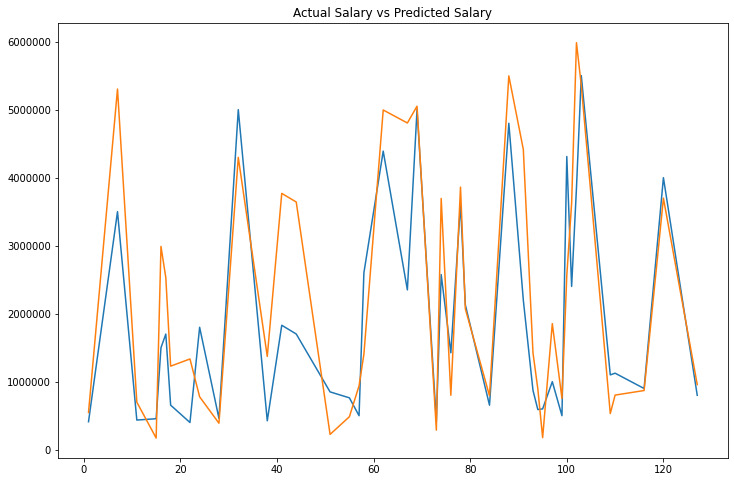

In [0]:
# wide swings between predicted and actual
plt.figure(figsize=(12,8))
plt.title('Actual Salary vs Predicted Salary')
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.plot(compare_predictions3)

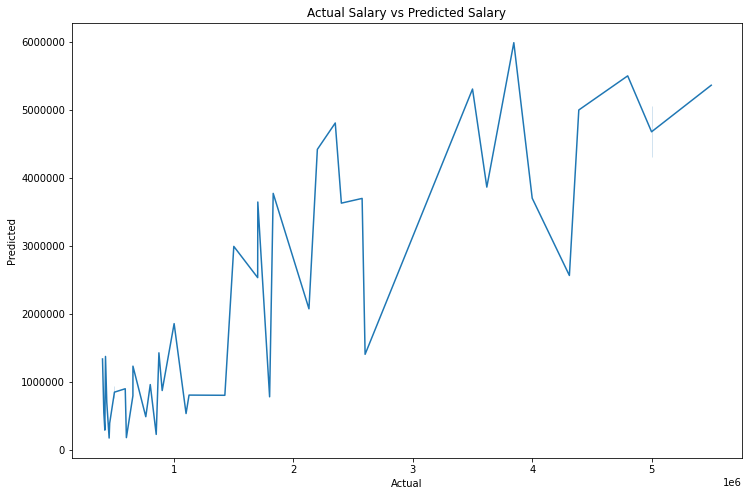

In [0]:
plt.figure(figsize=(12,8))
plt.title('Actual Salary vs Predicted Salary')
plt.xticks(np.arange(0, 6000000, step=1000000))
plt.ticklabel_format(style='plain', axis='y')
ax = sns.lineplot(x="Actual", y="Predicted",
                  markers=True, dashes=False, data=compare_predictions3)
plt.show()

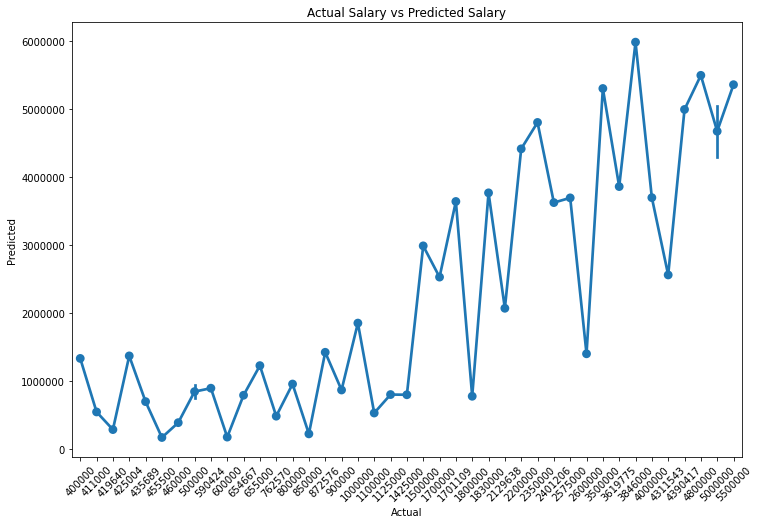

In [0]:
plt.figure(figsize=(12,8))
plt.title('Actual Salary vs Predicted Salary')
plt.xticks(np.arange(400000, 6000000, 50000.0))
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
ax = sns.pointplot(x="Actual", y="Predicted", dodge=True, data=compare_predictions3)
plt.show()

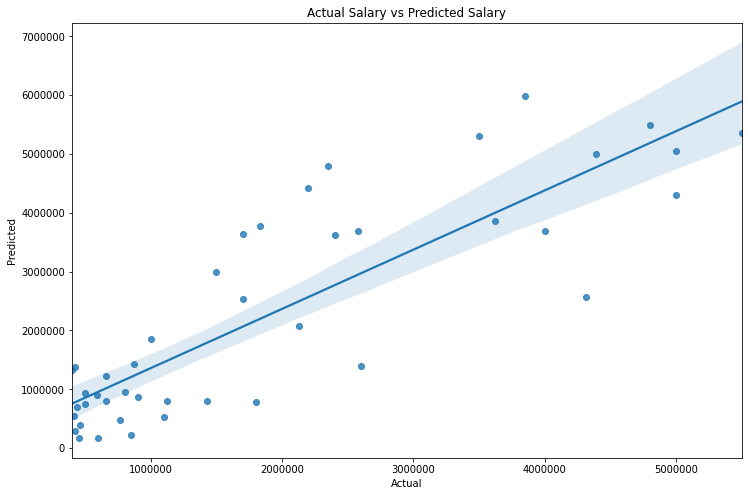

In [0]:
plt.figure(figsize=(12,8))
plt.title('Actual Salary vs Predicted Salary')
#plt.xticks(np.arange(400000, 6000000, 50000.0))
#plt.tick_params(axis='x', which='major', labelsize=3)
#plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
ax = sns.regplot(x="Actual", y="Predicted", data=compare_predictions3)
plt.show()

#reference: https://stackoverflow.com/questions/52523710/matplotlib-increase-spacing-between-points-on-x-axis


### Predict Syracuse salary using best linear model (model 3)

In [0]:
print(train_model3_fit.summary())


                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     17.12
Date:                Sat, 18 Apr 2020   Prob (F-statistic):           3.36e-17
Time:                        19:06:17   Log-Likelihood:                -1240.1
No. Observations:                  82   AIC:                             2512.
Df Residuals:                      66   BIC:                             2551.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.012e+05   1.69e+06      0.

In [0]:
Syr_if_AAC = round(syr_row3.loc[101, 'predict_schoolpay'],0)
print(syr_row3)
print("Recommended salary:")
Syr_if_AAC

          SchoolFullName Conf_Abbr  GSR      x4_Capacity  WinPercent  \
101  Syracuse University       ACC   80  119458953125000        0.57   

    TopWinners  MediaPay StateAbbr  MedianHHIncome  CollFanRank  TvRank  \
101      False         0        NY           60850        40.00    1.00   

     SchoolPay  runiform  AAC  ACC  Big12  BigTen  CUSA  Ind  MAC  MtWest  \
101    2401206      0.08    0    1      0       0     0    0    0       0   

     Pac12  SEC  SunBelt  predict_schoolpay  
101      0    0        0         3625620.46  
Recommended salary:


3625620.0

In [0]:
# if Syracuse were in the ACC
Syr_if_ACC = round((2.012e+05 + 1.117e+06 + (-1.196e+04*.80) + (6.567e+06*.57) + (-9.1539*60850) + (2621.8070*40) + -7365.6383), 0)
Syr_if_ACC

4592314.0

In [0]:
Syr_if_BigTen = round((2.012e+05 + 2.253e+06 + (-1.196e+04*.80) + (6.567e+06*.57) + (-9.1539*60850) + (2621.8070*40) + -7365.6383), 0)
Syr_if_BigTen

5728314.0

### Visualize suggested salary

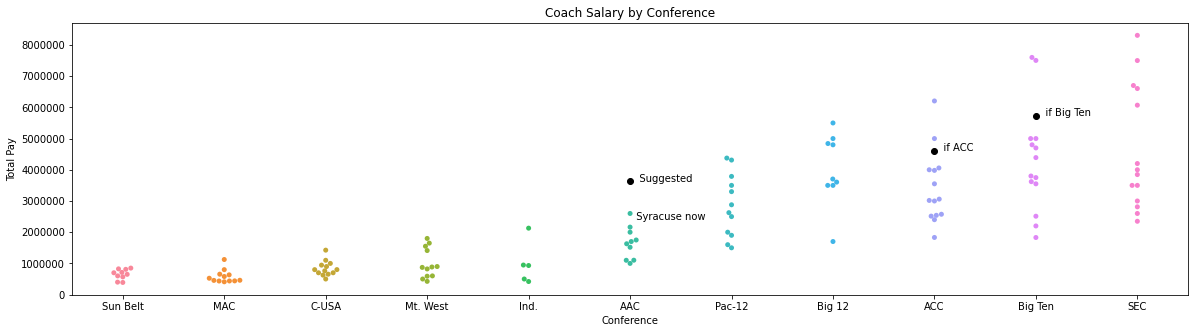

In [0]:
plt.figure(figsize=(20,5))
plt.title('Coach Salary by Conference')
plt.ticklabel_format(style='plain', axis='y')

ax = sns.swarmplot(x="Conf_Abbr", y="SchoolPay", data=coach1, 
                   order=[ "Sun Belt", "MAC", "C-USA", "Mt. West", "Ind.", "AAC", "Pac-12", "Big 12", "ACC", "Big Ten", "SEC"]
                   )
ax.text(5, coach1.loc[coach1.School =='Syracuse', 'SchoolPay'], "  Syracuse now", 
        horizontalalignment='left', size='medium', color='black')

ax.annotate('   Suggested', xy=(5, 3625620.0))
ax.plot([5], [3625620.0], 'o', color='black')
ax.annotate('   if ACC', xy=(8, 4592314.0))
ax.plot([8], [4592314.0], 'o', color='black')
ax.annotate('   if Big Ten', xy=(9, 5728314.0))
ax.plot([9], [5728314.0], 'o', color='black')
ax.set(xlabel='Conference', ylabel='Total Pay')
plt.show()

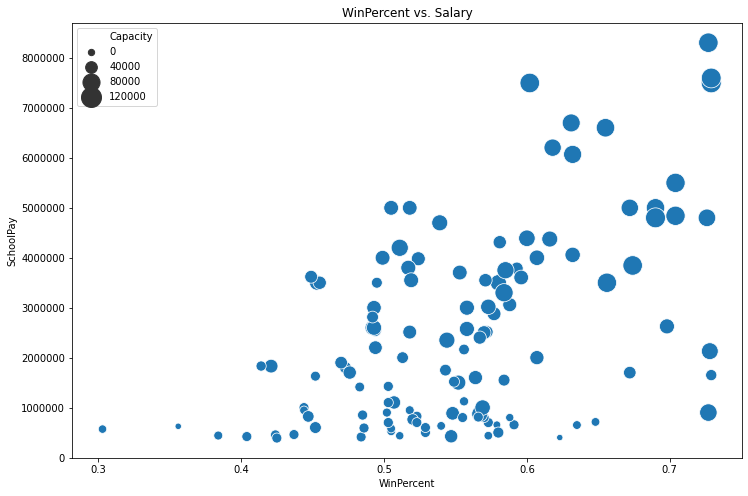

In [0]:
plt.figure(figsize=(12,8))
plt.title('WinPercent vs. Salary')
plt.xticks(np.arange(0, 1, step=0.1))
plt.ticklabel_format(style='plain', axis='y')

ax = sns.scatterplot(x="WinPercent", y="SchoolPay",  size="Capacity", sizes=(40, 400),
                     data=coach10b)
#hue="Conf_Abbr",
plt.show()


# Recommendations

The full set of recommendations for the athletic director are in the written report. They don't want all the details that are above in the code. 

For the salary negotiation, the model suggests a salary between approximately 2.6 million dollars and 4.6 million dollars, with 3.6 million dollars as the midpoint. That's a big increase from the current salary and Syracuse is already the highest paid in the AAC, so it may be productive to start the negotiation near the low end (2.6 million). 

Just like football teams, data models can always improve. In the next iteration of the model, the analyst should consider:

* Getting more data, both more observations (such as more years of data for the same schools) and more attributes (such as coach tenure, assistant coach pay, player/staff reviews of the head coach, the rate at which players go pro, etc.)
* an analysis of cases to determine if there are certain groups that the model consistently over or under predicts
* different data transformations, such as predicting the log of the salary instead of the salary
* different models. I used linear regression here, but it is worth trying others such as Random Forest, Decision Trees, and Naive Bayes. 
* It's also worth considering whether the model should emphasize factors that are most closely tied to money-making (stadium size, number of parking spots available near the stadium, cost of concessions per attendee) or those that are tied to the coach's performance. If the coach is evaluated on things that he can influence (win percentage, GSR, rates of legal charges against players, ratings by players and staff) then he would be motivated to improve in order to have a chance at a bigger salary increase next year. Separate analysis could be done to determine which of the under-coach-control factors have the most potential. 






